## DATA PROCESSING

In [151]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import datetime
from datetime import datetime
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# Import the data into their respective dataframes
dataframes = {}
for dirname, _, filenames in os.walk('./football_dataset/'):
    for filename in filenames:
        file_name = filename.split('.')[0] + "_df"
        filepath = os.path.join(dirname, filename)
        df = pd.read_csv(filepath, sep=",", encoding="UTF-8")
        dataframes[file_name] = df
        print(file_name, df.shape)

print('\nData imported')

appearances_df (1643394, 13)
clubs_df (439, 17)
club_games_df (143016, 11)
competitions_df (44, 11)
games_df (71508, 23)
game_events_df (994836, 10)
game_lineups_df (2191911, 10)
players_df (32409, 23)
player_valuations_df (487916, 5)
transfers_df (77936, 10)

Data imported


In [3]:
# Initialise the dataframes so that there is no undefined error
appearances_df = dataframes['appearances_df']
clubs_df = dataframes['clubs_df']
club_games_df = dataframes['club_games_df']
competitions_df = dataframes['competitions_df']
games_df = dataframes['games_df']
game_events_df = dataframes['game_events_df']
game_lineups_df = dataframes['game_lineups_df']
players_df = dataframes['players_df']
player_valuations_df = dataframes['player_valuations_df']
transfers_df = dataframes['transfers_df']

In [4]:
# Remove useless columns
players_df = players_df.drop(columns=["image_url", "url", "contract_expiration_date", "last_season"])

# Drop players without a date of birth
players_df['date_of_birth'] = pd.to_datetime(players_df['date_of_birth'])
players_df = players_df[players_df['date_of_birth'].isnull() == False]

# Drop players without a market value
players_df = players_df[players_df.highest_market_value_in_eur.isnull() == False]

# Set players' ages to realtime
now = datetime.now()
players_df['age'] = (now - players_df['date_of_birth']).apply(lambda x: x.days) / 365.25
players_df['age'] = players_df['age'].round().astype(int) 
players_df

,player_id,first_name,last_name,name,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,agent_name,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur,age
0,10,Miroslav,Klose,Miroslav Klose,398,miroslav-klose,Poland,Opole,Germany,1978-06-09,Centre-Forward,Attack,right,184.0,ASBW Sport Marketing,IT1,Società Sportiva Lazio S.p.A.,1000000.0,30000000.0,46
1,26,Roman,Weidenfeller,Roman Weidenfeller,16,roman-weidenfeller,Germany,Diez,Germany,1980-08-06,Goalkeeper,Goalkeeper,left,190.0,Neubauer 13 GmbH,L1,Borussia Dortmund,750000.0,8000000.0,44
2,65,Dimitar,Berbatov,Dimitar Berbatov,1091,dimitar-berbatov,Bulgaria,Blagoevgrad,Bulgaria,1981-01-30,Centre-Forward,Attack,NaN,NaN,CSKA-AS-23 Ltd.,GR1,Panthessalonikios Athlitikos Omilos Konstantin...,1000000.0,34500000.0,44
3,77,NaN,Lúcio,Lúcio,506,lucio,Brazil,Brasília,Brazil,1978-05-08,Centre-Back,Defender,NaN,NaN,NaN,IT1,Juventus Football Club,200000.0,24500000.0,47
4,80,Tom,Starke,Tom Starke,27,tom-starke,East Germany (GDR),Freital,Germany,1981-03-18,Goalkeeper,Goalkeeper,right,194.0,IFM,L1,FC Bayern München,100000.0,3000000.0,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32400,1294049,Tomás,Silva,Tomás Silva,2503,tomas-silva,Portugal,Porto,Portugal,2006-05-25,Left-Back,Defender,left,175.0,TGC,PO1,Boavista Futebol Clube,100000.0,100000.0,18
32401,1294052,João,Barros,João Barros,2503,joao-barros,Portugal,Porto,Portugal,2006-01-10,Left Winger,Attack,right,184.0,AGREF International,PO1,Boavista Futebol Clube,150000.0,150000.0,19
32403,1296876,Marc,Domènech,Marc Domènech,237,marc-domenech,Spain,Llucmajor,Spain,2006-12-01,Centre-Forward,Attack,NaN,NaN,NaN,ES1,Real Club Deportivo Mallorca S.A.D.,500000.0,500000.0,18
32404,1302421,NaN,João Neto,João Neto,6992,joao-neto,NaN,NaN,Brazil,2003-02-04,Right Winger,Attack,right,178.0,ADRIANO SPORTS,UKR1,ZAO FK Chornomorets Odessa,100000.0,100000.0,22


In [5]:
# Add year to player valuations
player_valuations_df['date']=pd.to_datetime(player_valuations_df['date'], format="%Y-%m-%d")
player_valuations_df['year']=player_valuations_df['date'].dt.year

# Add position to player valuations
position_df = players_df.copy()
position_df = position_df.drop(['name', 'current_club_id', 'current_club_name', 'country_of_citizenship', 'country_of_birth', 'city_of_birth', 'date_of_birth', 'foot', 'height_in_cm', 'market_value_in_eur', 'highest_market_value_in_eur', 'current_club_domestic_competition_id', 'first_name', 'last_name', 'player_code', 'age'], axis=1)
player_valuations_df = player_valuations_df.merge(position_df, left_on='player_id', right_on='player_id')
player_valuations_df

,player_id,date,market_value_in_eur,current_club_id,player_club_domestic_competition_id,year,sub_position,position,agent_name
0,405973,2000-01-20,150000,3057,BE1,2000,Left Winger,Attack,NaN
1,405973,2016-02-07,250000,3057,BE1,2016,Left Winger,Attack,NaN
2,405973,2016-07-15,250000,3057,BE1,2016,Left Winger,Attack,NaN
3,405973,2017-01-01,150000,3057,BE1,2017,Left Winger,Attack,NaN
4,405973,2018-09-11,75000,3057,BE1,2018,Left Winger,Attack,NaN
...,...,...,...,...,...,...,...,...,...
487350,897479,2024-10-09,500000,82,L1,2024,Attacking Midfield,Midfield,CAA Stellar
487351,1296876,2024-10-11,500000,237,ES1,2024,Centre-Forward,Attack,NaN
487352,1121298,2024-10-14,500000,366,ES1,2024,Centre-Back,Defender,NaN
487353,1255616,2024-10-14,200000,3709,ES1,2024,Attacking Midfield,Midfield,Best of You


In [6]:
# add year to player appearances
appearances_df['date'] = pd.to_datetime(appearances_df['date'], format="%Y-%m-%d")
appearances_df['year'] = appearances_df['date'].dt.year

# add position to appearances
value_df = players_df.copy()
value_df = value_df.drop(['name', 'current_club_id', 'current_club_name', 'country_of_citizenship', 'country_of_birth', 'city_of_birth', 'date_of_birth', 'foot', 'height_in_cm', 'sub_position', 'highest_market_value_in_eur', 'current_club_domestic_competition_id', 'first_name', 'last_name', 'player_code', 'age'], axis=1)
appearances_df1 = value_df.merge(appearances_df, left_on='player_id', right_on='player_id')
appearances_df1

,player_id,position,agent_name,market_value_in_eur,appearance_id,game_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played,year
0,10,Attack,ASBW Sport Marketing,1000000.0,2254965_10,2254965,398,398,2012-08-23,Miroslav Klose,ELQ,1,0,1,0,83,2012
1,10,Attack,ASBW Sport Marketing,1000000.0,2251263_10,2251263,398,398,2012-08-26,Miroslav Klose,IT1,1,0,0,0,90,2012
2,10,Attack,ASBW Sport Marketing,1000000.0,2251277_10,2251277,398,398,2012-09-02,Miroslav Klose,IT1,1,0,2,0,89,2012
3,10,Attack,ASBW Sport Marketing,1000000.0,2251283_10,2251283,398,398,2012-09-16,Miroslav Klose,IT1,0,0,1,0,90,2012
4,10,Attack,ASBW Sport Marketing,1000000.0,2262399_10,2262399,398,398,2012-09-20,Miroslav Klose,EL,0,0,0,0,90,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641823,1302421,Attack,ADRIANO SPORTS,100000.0,4431147_1302421,4431147,6992,6992,2024-08-21,João Neto,UKRP,0,0,0,0,90,2024
1641824,1302421,Attack,ADRIANO SPORTS,100000.0,4368761_1302421,4368761,6992,6992,2024-08-26,João Neto,UKR1,0,0,0,0,21,2024
1641825,1302421,Attack,ADRIANO SPORTS,100000.0,4368736_1302421,4368736,6992,6992,2024-08-31,João Neto,UKR1,0,0,0,0,14,2024
1641826,1302421,Attack,ADRIANO SPORTS,100000.0,4368868_1302421,4368868,6992,6992,2024-09-14,João Neto,UKR1,0,0,0,0,45,2024


## DATA EXPLORATION

### We will filter player's statistics and valuation to be limited to up till 2022

### Let's observe the players' information

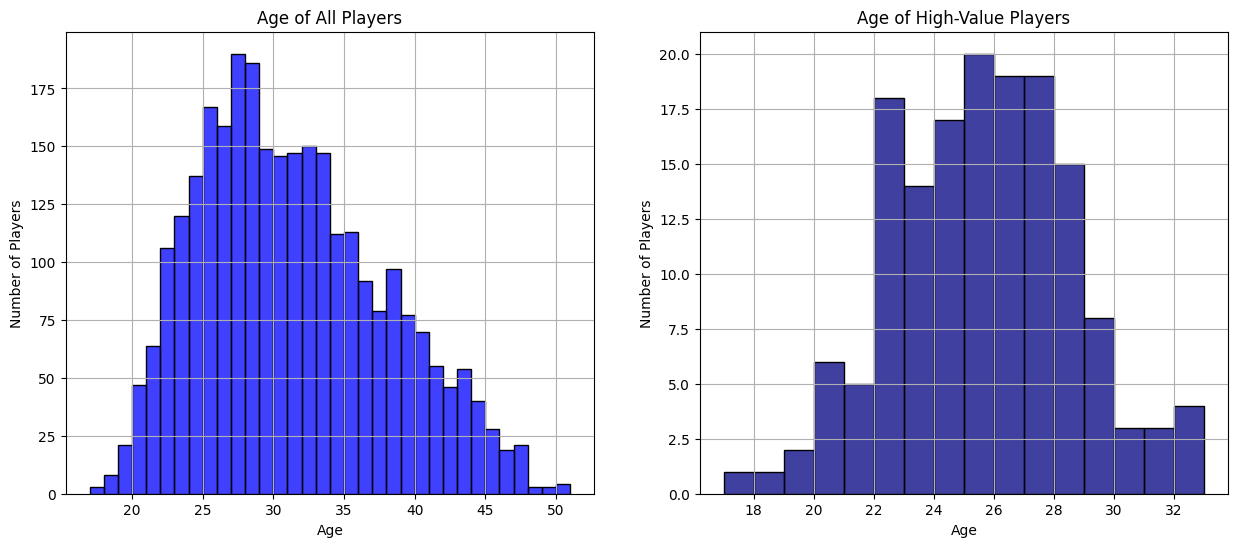

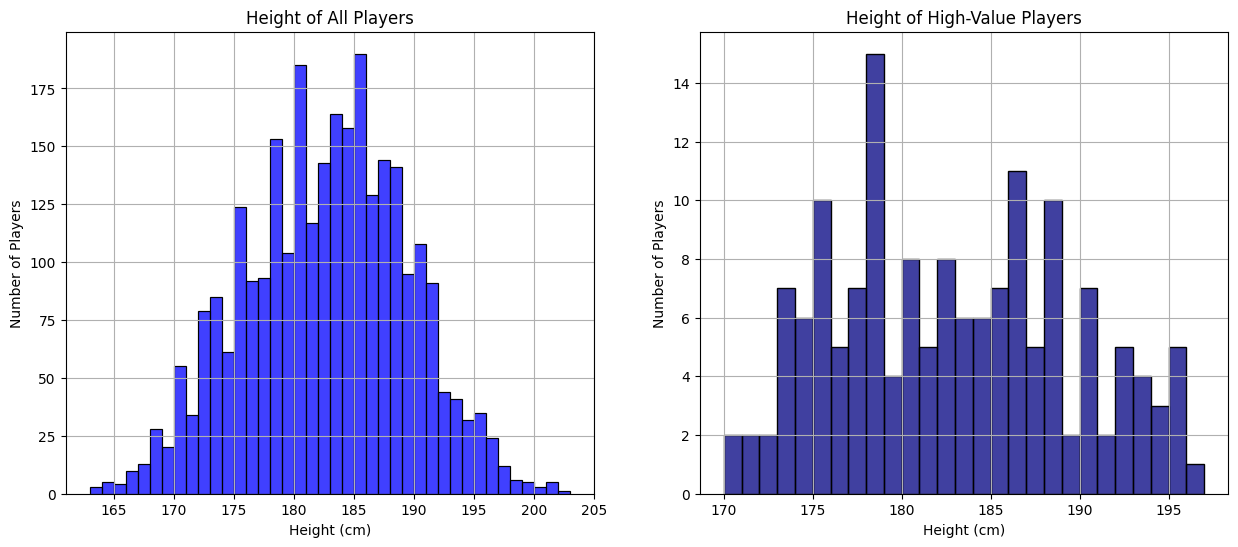

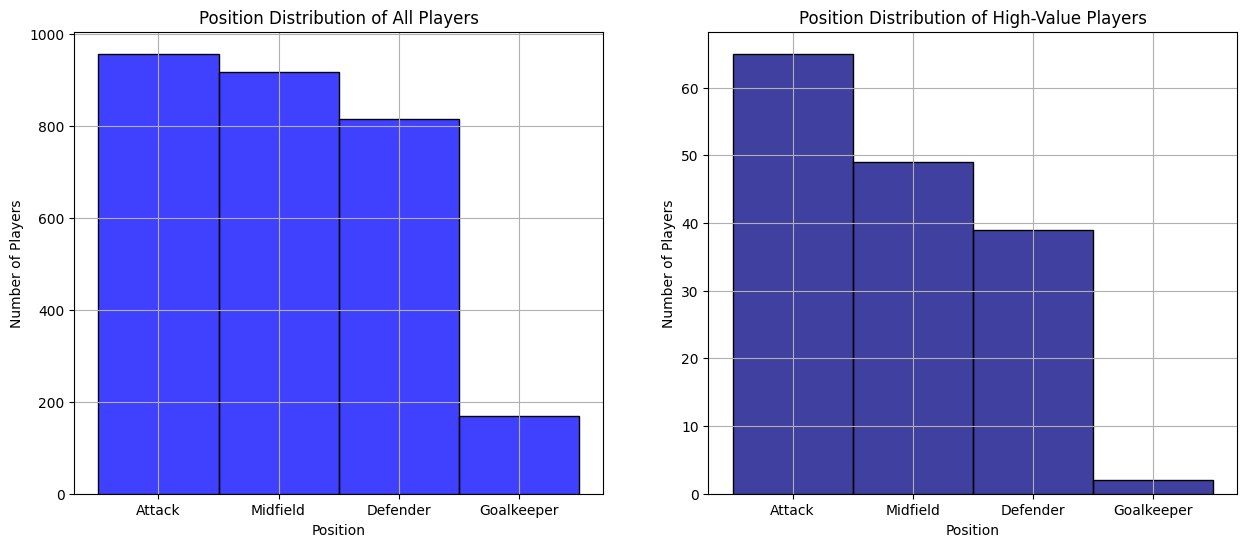

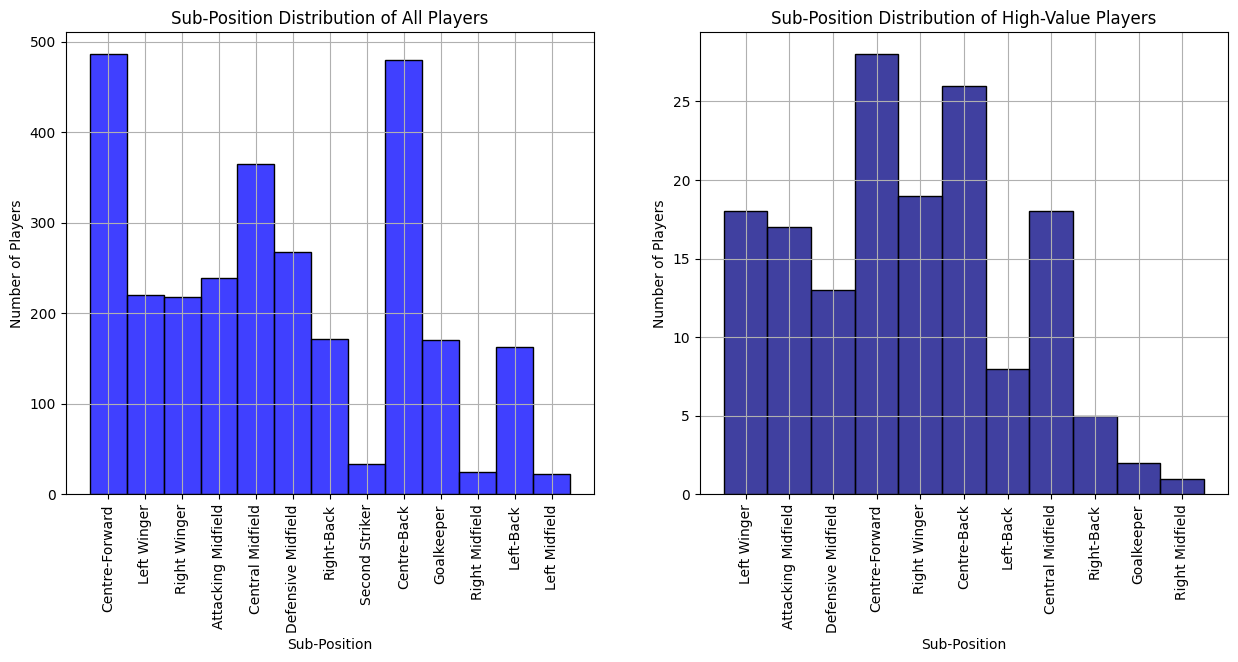

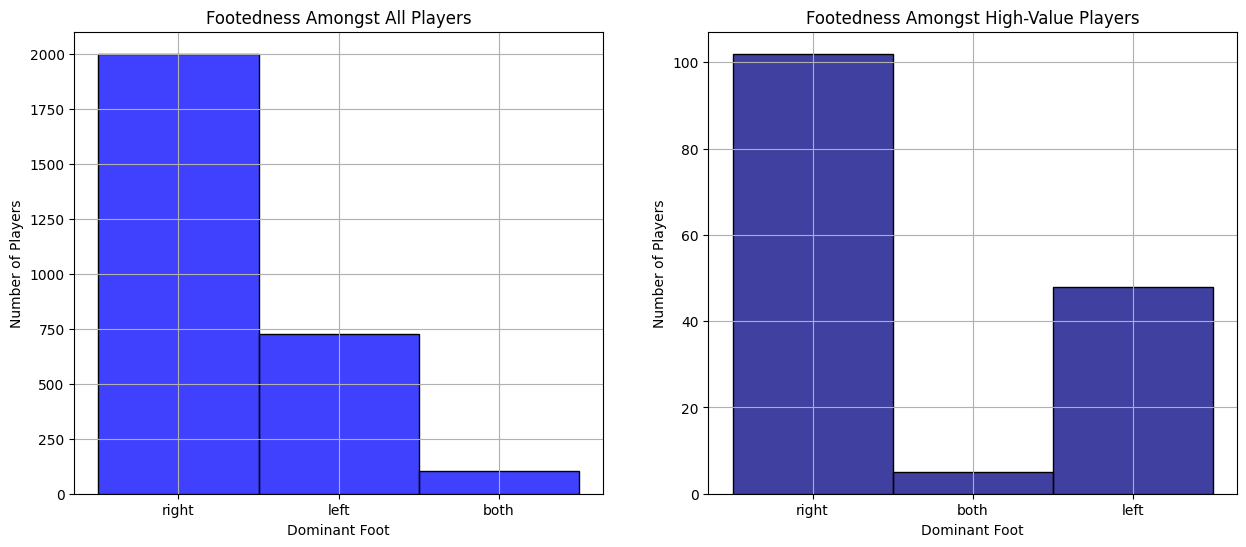

In [7]:
# Filter and sort the dataset
def preprocess_players_data(players_df):
    players_df_filtered = players_df[players_df['highest_market_value_in_eur'].notnull()]
    players_df_filtered = players_df_filtered[players_df_filtered['highest_market_value_in_eur'] >= 10000000]
    high_value_players_df = players_df_filtered[players_df_filtered['market_value_in_eur'] > 40000000]
    return players_df_filtered.sort_values("highest_market_value_in_eur", ascending=False), high_value_players_df

players_df1, high_value_players_df = preprocess_players_data(players_df)

# Plot distribution by a single variable
def plot_distribution(data, variable, title, xlabel, color, position, binwidth=1, rotation=0):
    plt.subplot(position)
    sns.histplot(data=data, x=variable, binwidth=binwidth, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Number of Players')
    plt.xticks(rotation=rotation)
    plt.grid(True)

# Plot distributions for age and height of players
def plot_age_and_height_distributions(players_df, high_value_players_df):
    plt.figure(figsize=(15, 6))

    plot_distribution(players_df, 'age', 'Age of All Players', 'Age', 'b', 121)
    plot_distribution(high_value_players_df, 'age', 'Age of High-Value Players', 'Age', 'navy', 122)

    plt.show()

    plt.figure(figsize=(15, 6))
    players_with_height = players_df[players_df['height_in_cm'].notnull()]

    plot_distribution(players_with_height, 'height_in_cm', 'Height of All Players', 'Height (cm)', 'b', 121)
    plot_distribution(high_value_players_df, 'height_in_cm', 'Height of High-Value Players', 'Height (cm)', 'navy', 122)

    plt.show()

# Plot position and sub-position distributions for players
def plot_position_distributions(players_df, high_value_players_df):
    plt.figure(figsize=(15, 6))

    plot_distribution(players_df, 'position', 'Position Distribution of All Players', 'Position', 'b', 121)
    plot_distribution(high_value_players_df, 'position', 'Position Distribution of High-Value Players', 'Position', 'navy', 122)

    plt.show()

    plt.figure(figsize=(15, 6))
    
    plot_distribution(players_df, 'sub_position', 'Sub-Position Distribution of All Players', 'Sub-Position', 'b', 121, rotation=90)
    plot_distribution(high_value_players_df, 'sub_position', 'Sub-Position Distribution of High-Value Players', 'Sub-Position', 'navy', 122, rotation=90)

    plt.show()

# Plot footedness for players
def plot_footedness_distributions(players_df, high_value_players_df):
    plt.figure(figsize=(15, 6))

    plot_distribution(players_df, 'foot', 'Footedness Amongst All Players', 'Dominant Foot', 'b', 121)
    plot_distribution(high_value_players_df, 'foot', 'Footedness Amongst High-Value Players', 'Dominant Foot', 'navy', 122)

    plt.show()

# Run the plotting functions
plot_age_and_height_distributions(players_df1, high_value_players_df)
plot_position_distributions(players_df1, high_value_players_df)
plot_footedness_distributions(players_df1, high_value_players_df)

### Let's look at the player valuations over time, as well as sorted into Attack, Goalkeeper, Defender and Midfield

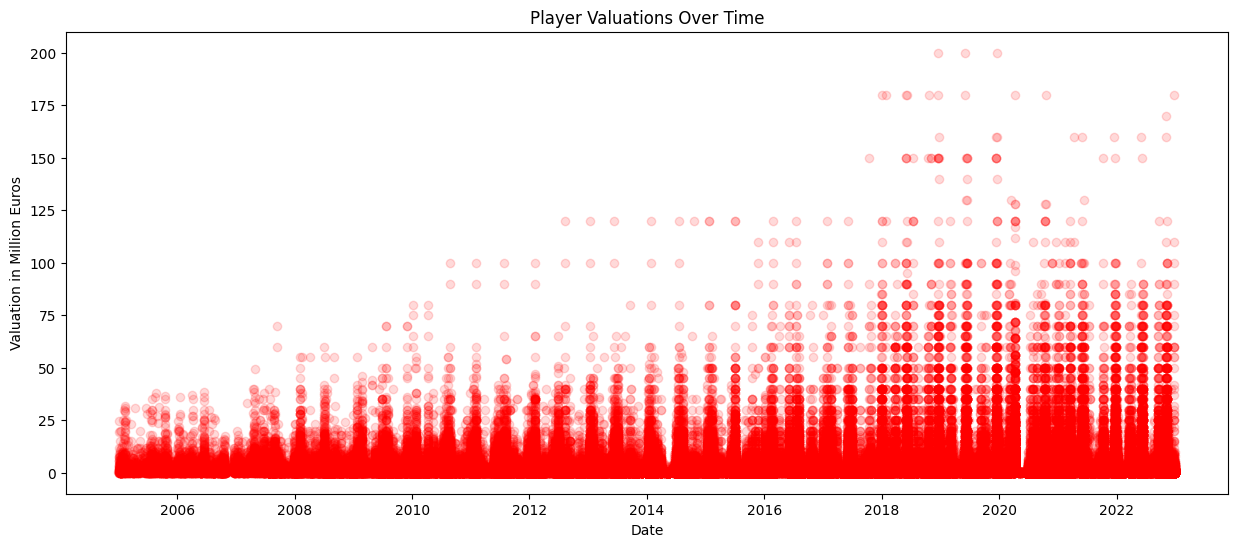

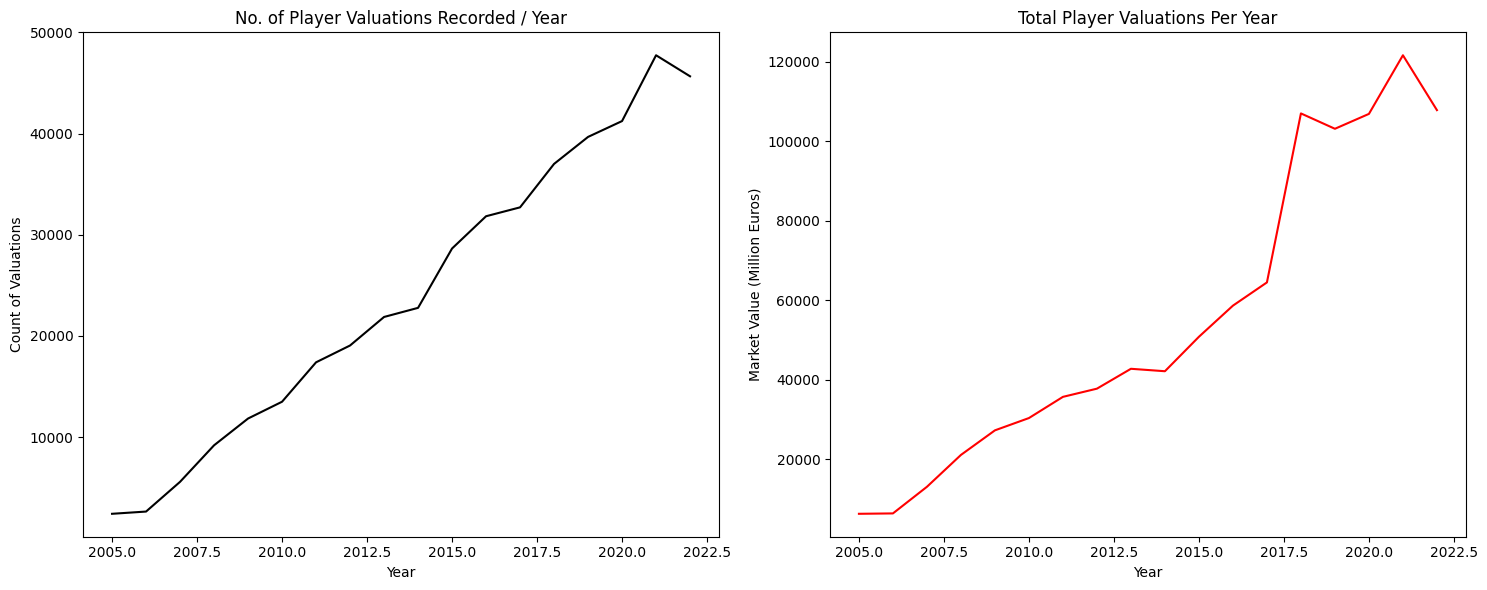

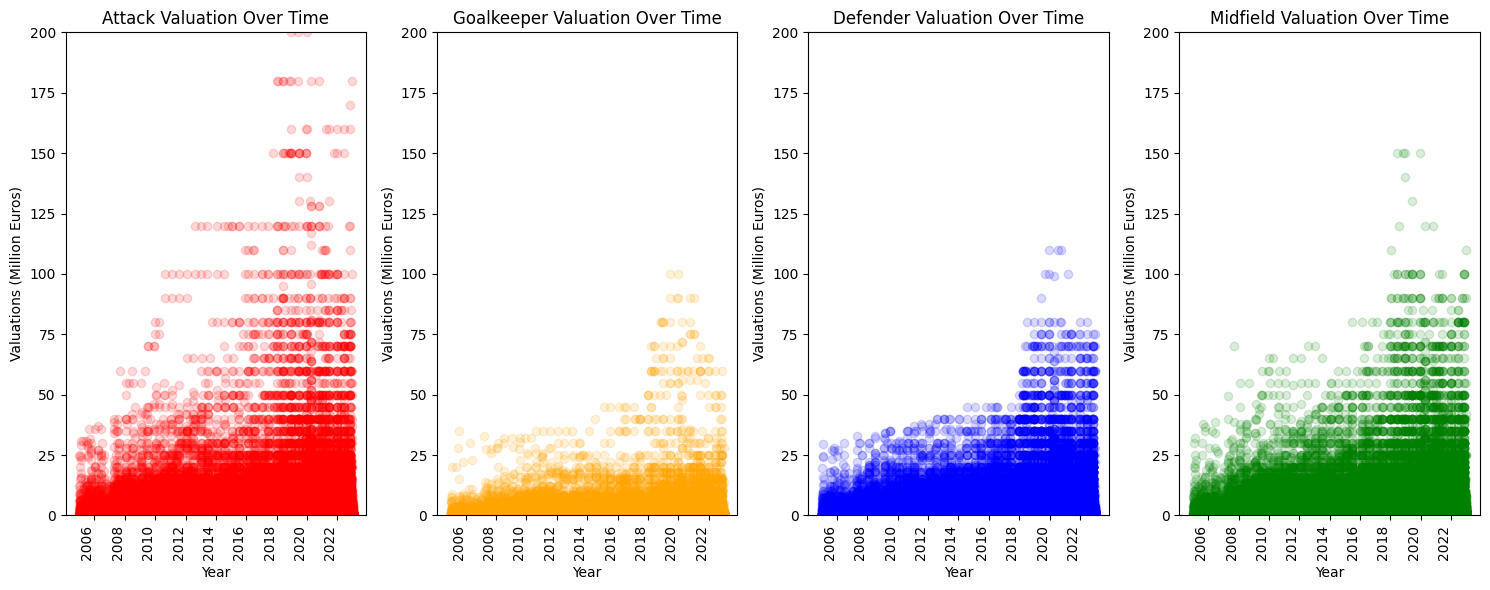

In [8]:
# Filter data based on year and market value
player_valuations_df = player_valuations_df[(player_valuations_df.year > 2004) & (player_valuations_df.year < 2023)]
high_value_player_valuations_df = player_valuations_df[player_valuations_df.market_value_in_eur > 40000000]
positions = players_df.position.unique()

# Overall player valuations over time
plt.figure(figsize=(15, 6))
plt.scatter(player_valuations_df['date'], player_valuations_df['market_value_in_eur'] / 1e6, color='red', alpha=0.15)
plt.xlabel('Date')
plt.ylabel('Valuation in Million Euros')
plt.title('Player Valuations Over Time')
plt.show()

# Yearly statistics on player valuations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Prepare yearly valuation statistics
yearly_counts = player_valuations_df.groupby('year')['market_value_in_eur'].count()
yearly_sums = player_valuations_df.groupby('year')['market_value_in_eur'].sum() / 1e6

# Plot the number of valuations recorded per year
ax1.plot(yearly_counts.index, yearly_counts, color='black')
ax1.set_title('No. of Player Valuations Recorded / Year')
ax1.set_xlabel('Year')
ax1.set_ylabel('Count of Valuations')

# Plot the sum of player valuations per year
ax2.plot(yearly_sums.index, yearly_sums, color='red')
ax2.set_title('Total Player Valuations Per Year')
ax2.set_xlabel('Year')
ax2.set_ylabel('Market Value (Million Euros)')

plt.tight_layout()
plt.show()

# Valuation data over time by player position
plt.figure(figsize=(15, 6))
colors = ['red', 'orange', 'blue', 'green', 'yellow']

positions = positions[:4]  
for i, position in enumerate(positions):
    plt.subplot(1, 4, i + 1)
    position_data = player_valuations_df[player_valuations_df.position == position]
    plt.scatter(position_data['date'], position_data['market_value_in_eur'] / 1e6, color=colors[i], alpha=0.15)
    plt.xlabel('Year')
    plt.ylabel('Valuations (Million Euros)')
    plt.title(f'{position} Valuation Over Time')
    plt.ylim(0, 200)
    plt.xticks(rotation=90, ha='right')

plt.tight_layout()
plt.show()

### Observe more specific player valuations based on age

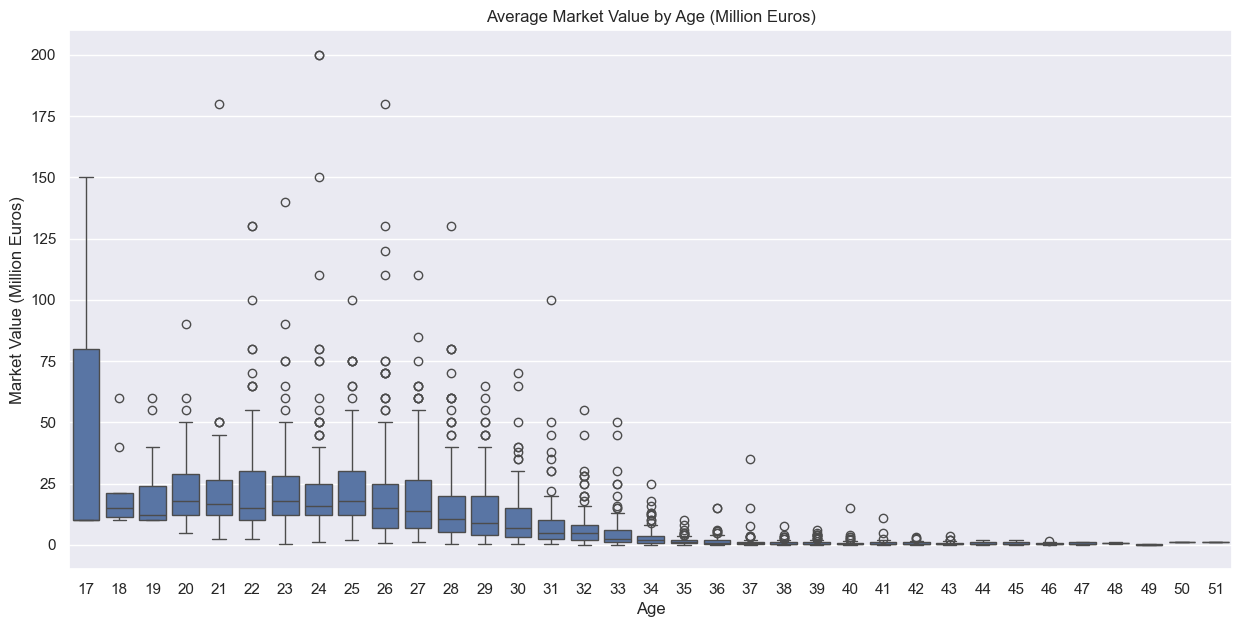

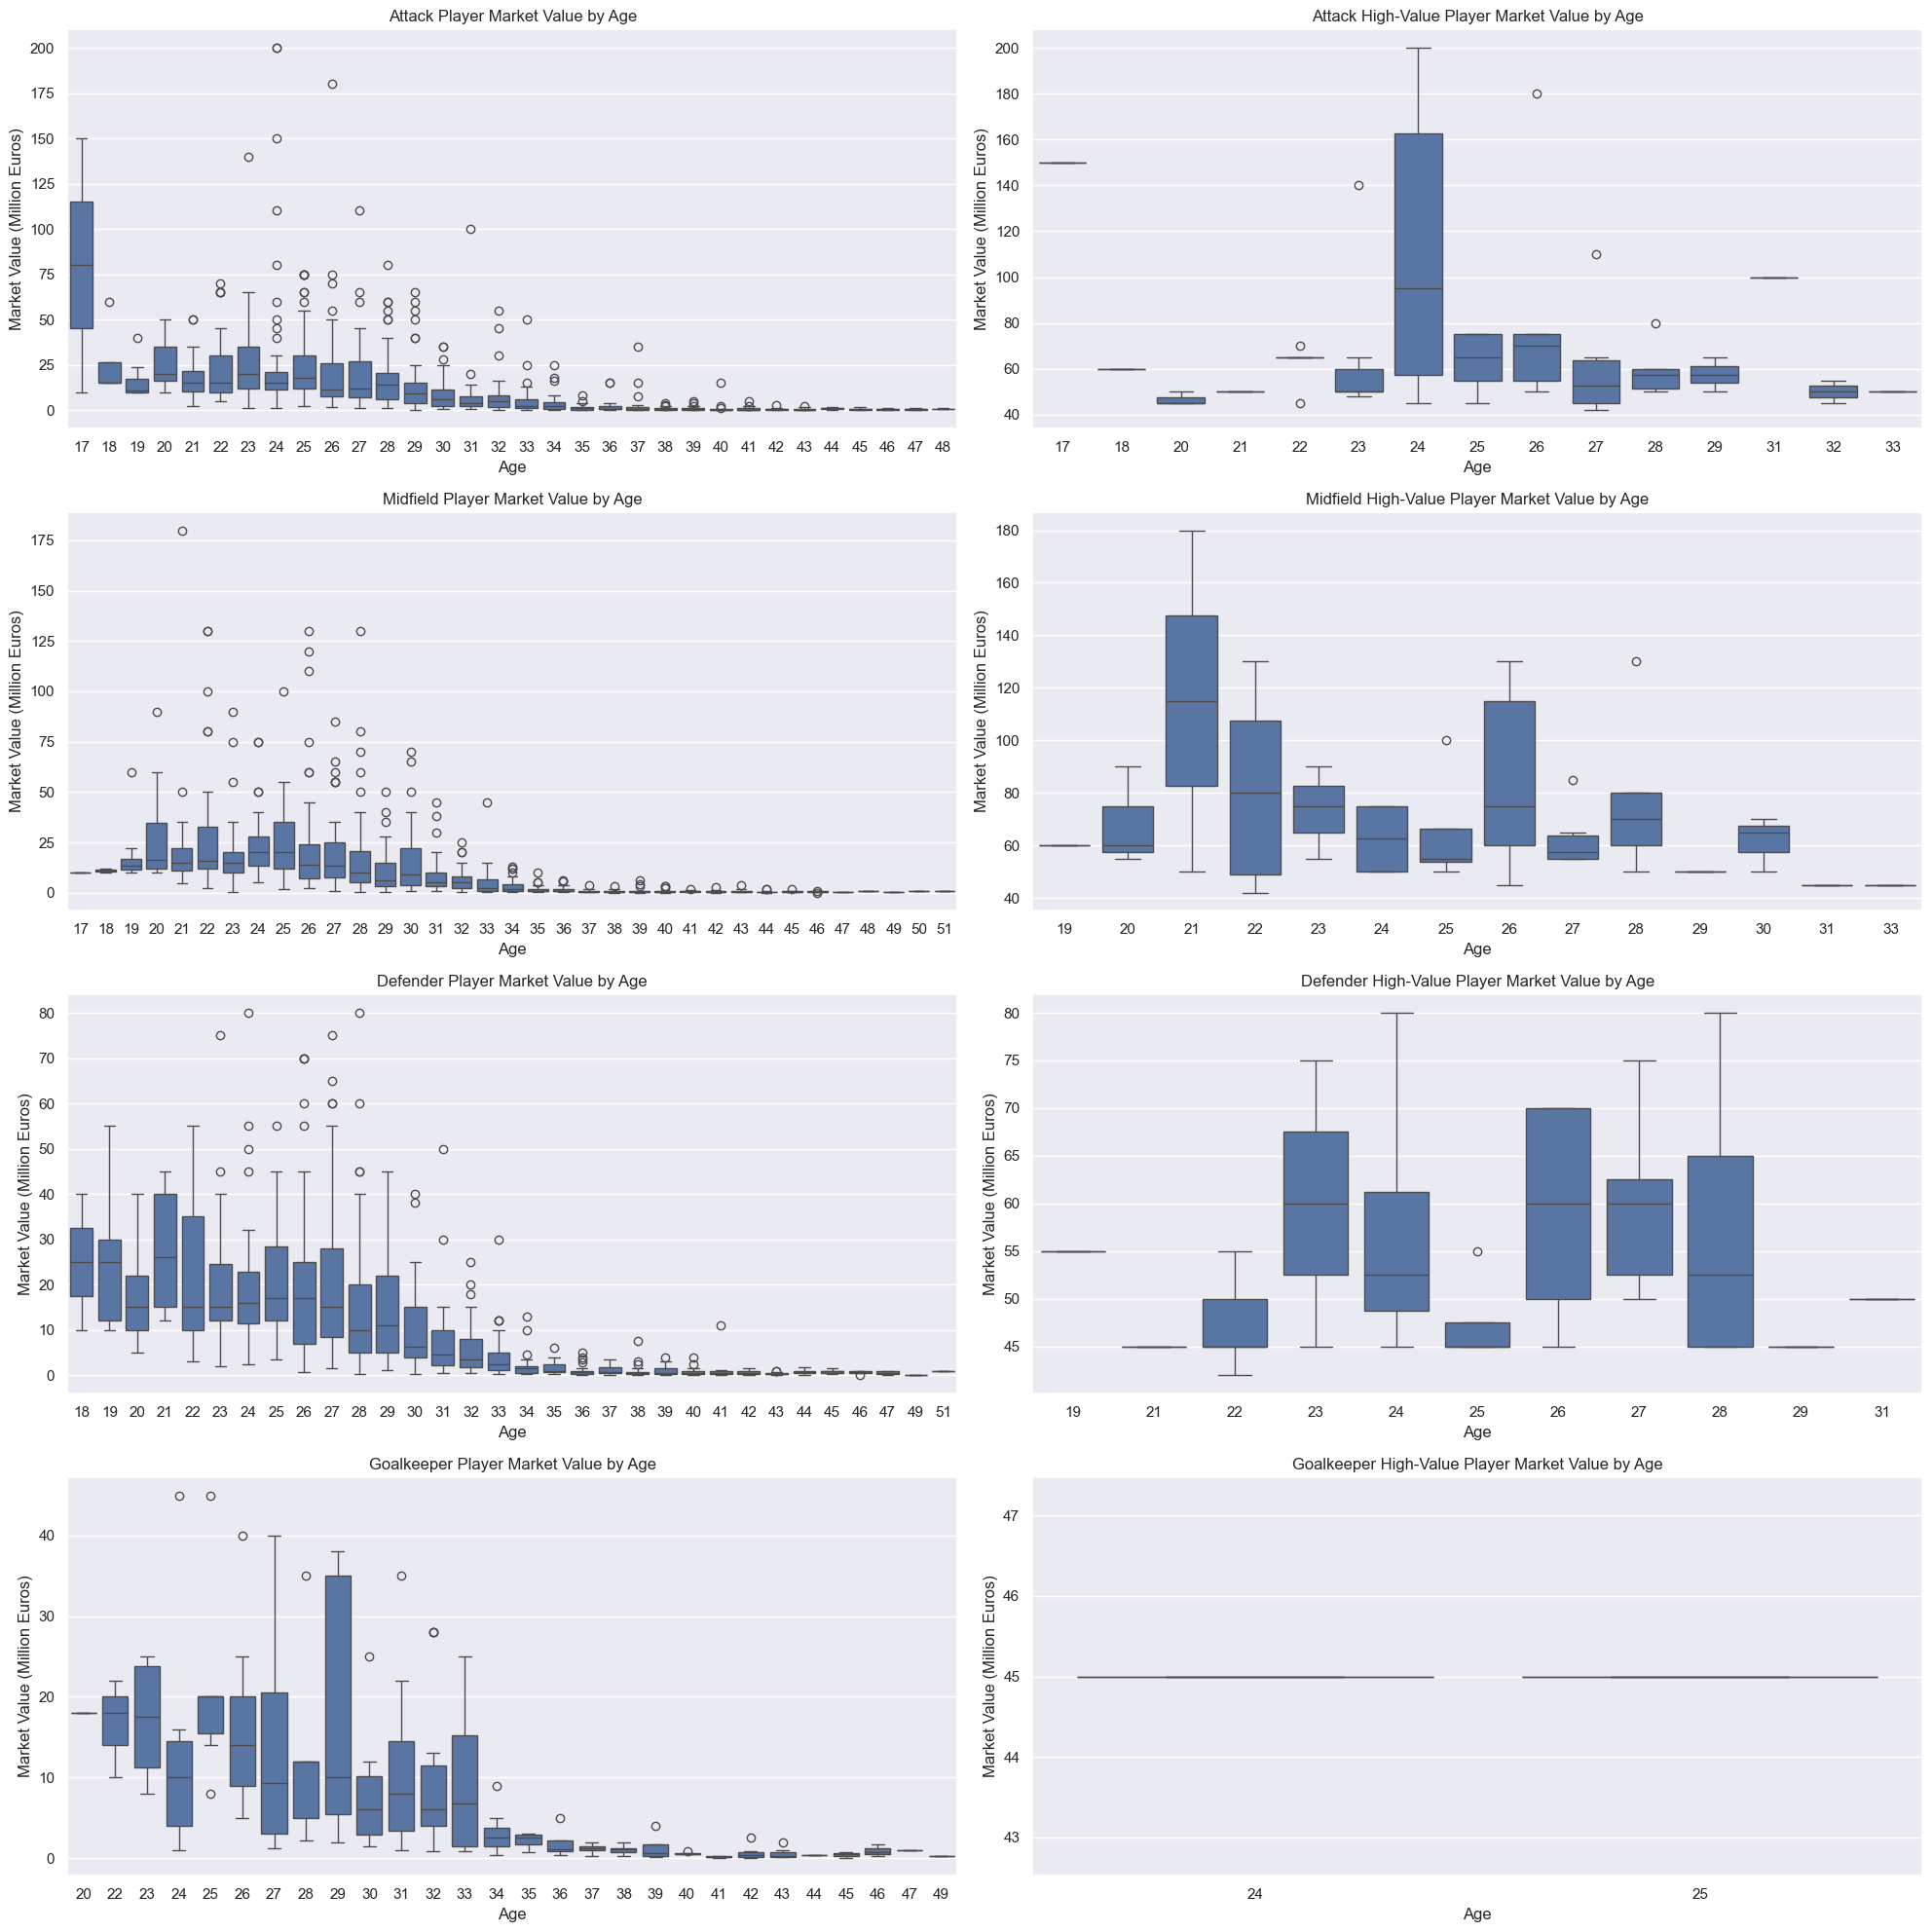

In [9]:
# Set color palette to rainbow
sns.set_palette("rainbow")

# Function to plot average market value by age for all players
def plot_market_value_by_age(data, title):
    sns.set(rc={'figure.figsize': (15, 7)})
    plt.figure()
    sns.boxplot(x=data["age"], y=data['market_value_in_eur'] / 1e6)
    plt.title(title)
    plt.ylabel('Market Value (Million Euros)')
    plt.xlabel('Age')
    plt.show()

# Function to plot market value by age for each position
def plot_market_value_by_position(data, high_value_data):
    unique_positions = data['position'].unique()
    plt.figure(figsize=(20, 20))

    for i, position in enumerate(unique_positions, 1):
        position_data = data[data['position'] == position]
        high_value_position_data = high_value_data[high_value_data['position'] == position]

        # Plot for all players in the position
        plt.subplot(len(unique_positions), 2, i * 2 - 1)
        sns.boxplot(x=position_data["age"], y=position_data['market_value_in_eur'] / 1e6)
        plt.title(f"{position} Player Market Value by Age")
        plt.ylabel('Market Value (Million Euros)')
        plt.xlabel('Age')

        # Plot for high-value players in the position
        plt.subplot(len(unique_positions), 2, i * 2)
        sns.boxplot(x=high_value_position_data["age"], y=high_value_position_data['market_value_in_eur'] / 1e6)
        plt.title(f"{position} High-Value Player Market Value by Age")
        plt.ylabel('Market Value (Million Euros)')
        plt.xlabel('Age')

    plt.tight_layout()
    plt.show()

# Call the plotting functions
plot_market_value_by_age(players_df1, 'Average Market Value by Age (Million Euros)')
plot_market_value_by_position(players_df1, high_value_players_df)

### Observe more specific player valuations based on height

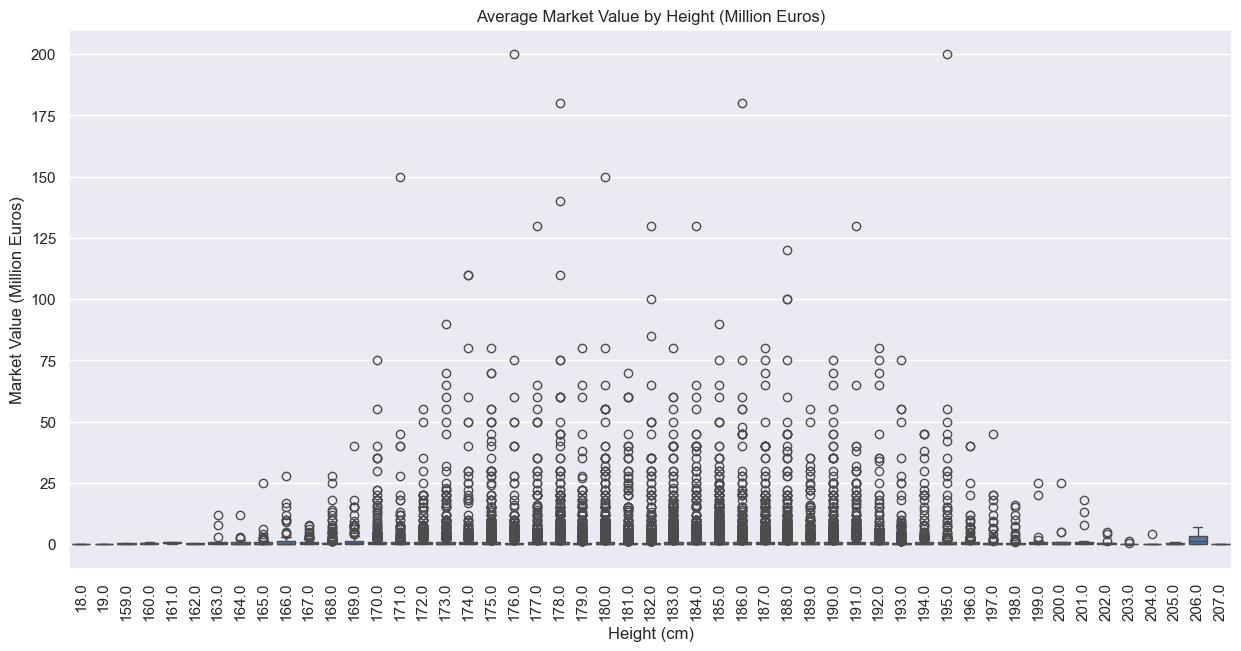

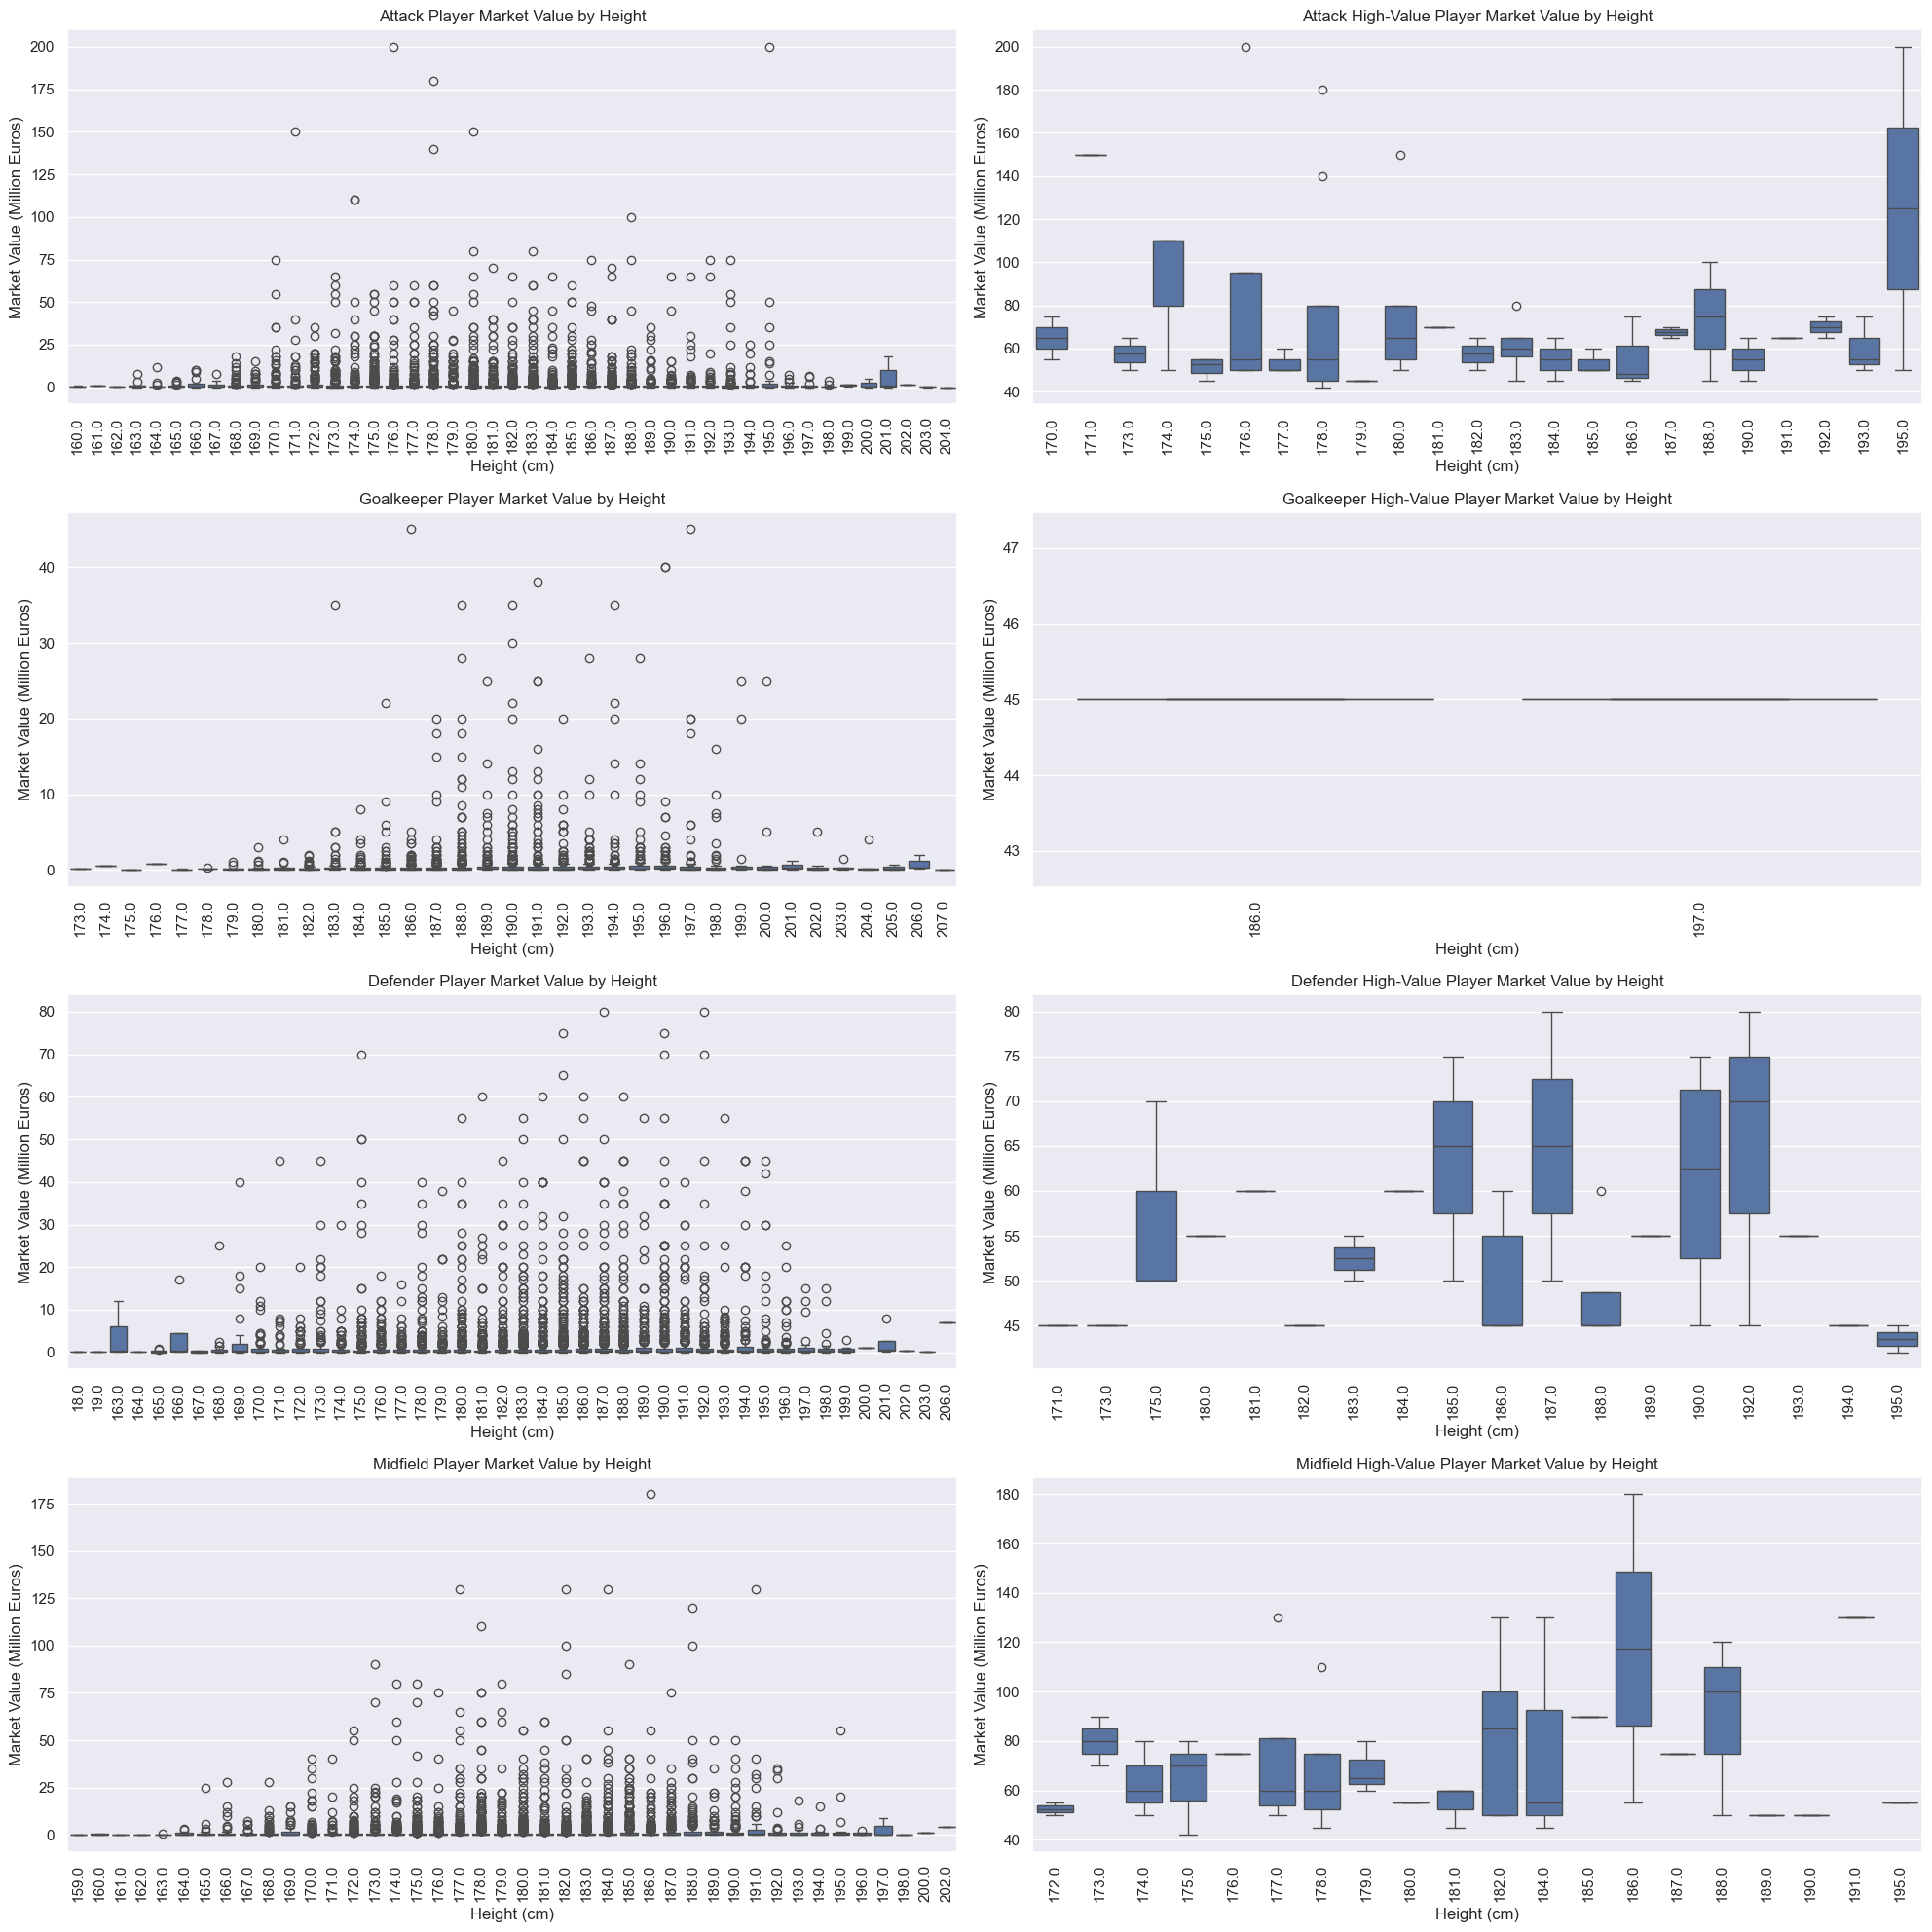

In [10]:
# Set color palette to rainbow
sns.set_palette("rainbow")

# Remove players with no height data
players_df3 = players_df[players_df['height_in_cm'] >= 1]

# Function to plot average market value by height for all players
def plot_market_value_by_height(data, title):
    sns.set(rc={'figure.figsize': (15, 7)})
    plt.figure()
    sns.boxplot(x=data["height_in_cm"], y=data['market_value_in_eur'] / 1e6)
    plt.title(title)
    plt.ylabel('Market Value (Million Euros)')
    plt.xlabel('Height (cm)')
    plt.xticks(rotation=90)  # Rotate x-axis labels
    plt.show()

# Function to plot market value by height for each position
def plot_market_value_by_position_height(data, high_value_data, positions):
    plt.figure(figsize=(20, 20))

    for i, position in enumerate(positions, 1):
        position_data = data[data['position'] == position]
        high_value_position_data = high_value_data[high_value_data['position'] == position]

        # Plot for all players in the position
        plt.subplot(len(positions), 2, i * 2 - 1)
        sns.boxplot(x=position_data["height_in_cm"], y=position_data['market_value_in_eur'] / 1e6)
        plt.title(f"{position} Player Market Value by Height")
        plt.ylabel('Market Value (Million Euros)')
        plt.xlabel('Height (cm)')
        plt.xticks(rotation=90)  # Rotate x-axis labels

        # Plot for high-value players in the position
        plt.subplot(len(positions), 2, i * 2)
        sns.boxplot(x=high_value_position_data["height_in_cm"], y=high_value_position_data['market_value_in_eur'] / 1e6)
        plt.title(f"{position} High-Value Player Market Value by Height")
        plt.ylabel('Market Value (Million Euros)')
        plt.xlabel('Height (cm)')
        plt.xticks(rotation=90)  # Rotate x-axis labels

    plt.tight_layout()
    plt.show()

# Call the plotting functions
plot_market_value_by_height(players_df3, 'Average Market Value by Height (Million Euros)')
plot_market_value_by_position_height(players_df3, high_value_players_df, positions)

### Players with the top market values

In [11]:
# Define high value players dataframe (players with market value > 40 million EUR)
high_value_players_df1 = players_df[players_df['market_value_in_eur'] > 40000000]
high_value_players_df2 = high_value_players_df1.sort_values('market_value_in_eur', ascending=False)
highest_value_players_df2 = high_value_players_df1.sort_values('highest_market_value_in_eur', ascending=False)

print(high_value_players_df2[['name', "market_value_in_eur"]].head(15))
print()
print(highest_value_players_df2[['name', "highest_market_value_in_eur"]].head(15))

                    name  market_value_in_eur
19987    Vinicius Junior          200000000.0
21632     Erling Haaland          200000000.0
25746    Jude Bellingham          180000000.0
18780      Kylian Mbappé          180000000.0
21316         Phil Foden          150000000.0
31099       Lamine Yamal          150000000.0
22062        Bukayo Saka          140000000.0
26118      Florian Wirtz          130000000.0
19515              Rodri          130000000.0
19864  Federico Valverde          130000000.0
25709      Jamal Musiala          130000000.0
19520        Declan Rice          120000000.0
21463            Rodrygo          110000000.0
21312   Lautaro Martínez          110000000.0
17626    Martin Ødegaard          110000000.0

                    name  highest_market_value_in_eur
18780      Kylian Mbappé                  200000000.0
21632     Erling Haaland                  200000000.0
19987    Vinicius Junior                  200000000.0
5941              Neymar                  18000

## DATA MERGING

### Now let's use 2022 information to train and predict player valuations

In [124]:
# Merge games and appearances
games_and_appearances_df = appearances_df.merge(games_df, on=['game_id'], how='left')
season = 2022
merged_players_df = players_df.drop(['current_club_id', 'city_of_birth', 'date_of_birth', 'first_name', 'last_name', 'player_code'], axis=1)

# Define the list of seasons you want to process
seasons = [2020, 2021, 2022, 2023]  # Example seasons

# Filter the DataFrame for the specified seasons
filtered_df = games_and_appearances_df[games_and_appearances_df['season'].isin(seasons)]

# Calculate 'goals_for'
filtered_df['goals_for'] = np.where(
    filtered_df['home_club_id'] == filtered_df['player_club_id'], 
    filtered_df['home_club_goals'], 
    np.where(
        filtered_df['away_club_id'] == filtered_df['player_club_id'], 
        filtered_df['away_club_goals'], 
        np.nan
    )
)

# Calculate 'goals_against'
filtered_df['goals_against'] = np.where(
    filtered_df['home_club_id'] == filtered_df['player_club_id'], 
    filtered_df['away_club_goals'], 
    np.where(
        filtered_df['away_club_id'] == filtered_df['player_club_id'], 
        filtered_df['home_club_goals'], 
        np.nan
    )
)

# Calculate 'clean_sheet'
filtered_df['clean_sheet'] = np.where(
    filtered_df['goals_against'] == 0, 
    1, 
    np.where(filtered_df['goals_against'] > 0, 0, np.nan)
)

# Aggregate statistics by player_id and season
aggregated_stats = filtered_df.groupby(['player_id', 'season']).agg({
    'goals': 'sum',
    'game_id': 'nunique',
    'assists': 'sum',
    'minutes_played': 'sum',
    'goals_for': 'sum',
    'goals_against': 'sum',
    'clean_sheet': 'sum',
    'yellow_cards': 'sum',
    'red_cards': 'sum'
}).rename(columns={'game_id': 'games'}).reset_index()

# Pivot the DataFrame to have seasons as suffixes
pivot_stats = aggregated_stats.pivot(index='player_id', columns='season')

# Flatten the MultiIndex columns
pivot_stats.columns = ['{}_{}'.format(stat, season) for stat, season in pivot_stats.columns]
pivot_stats = pivot_stats.reset_index()

# Merge with merged_players_df
merged_players_df = merged_players_df.merge(pivot_stats, on='player_id', how='left')

# Fill NaN values with zeros for seasons where players have no data
for season in seasons:
    for stat in ['games', 'goals', 'assists', 'minutes_played', 
                'goals_for', 'goals_against', 'clean_sheet', 
                'yellow_cards', 'red_cards']:
        column = f'{stat}_{season}'
        if column in merged_players_df.columns:
            merged_players_df[column] = merged_players_df[column].fillna(0)
        else:
            merged_players_df[column] = 0

print('Appearance, goal, and card data merged for multiple seasons (Vectorized)')
print(merged_players_df.info())

Appearance, goal, and card data merged for multiple seasons (Vectorized)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30843 entries, 0 to 30842
Data columns (total 50 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   player_id                             30843 non-null  int64  
 1   name                                  30843 non-null  object 
 2   country_of_birth                      28670 non-null  object 
 3   country_of_citizenship                30484 non-null  object 
 4   sub_position                          30743 non-null  object 
 5   position                              30843 non-null  object 
 6   foot                                  28872 non-null  object 
 7   height_in_cm                          29127 non-null  float64
 8   agent_name                            15954 non-null  object 
 9   current_club_domestic_competition_id  30843 non-null  object 
 10  current_c

In [125]:
# Merge competitions data to get the competition name and rankings (Based on UEFA Rankings)
merged_df = merged_players_df.copy()
merged_df = merged_df.rename(columns={'name': 'player_name'})
merged_df = merged_df.merge(competitions_df[['competition_id', 'name']], 
                                            left_on='current_club_domestic_competition_id', 
                                            right_on='competition_id', 
                                            how='left')

merged_df = merged_df.drop('competition_id', axis=1)
merged_df = merged_df.rename(columns={'name': 'competition_name'})

# Create a dictionary to assign numerical rankings to competitions (you can adjust the mapping)
competition_ranking = {
    "uefa-champions-league": 1,
    "uefa-europa-league": 2,
    "uefa-conference-league": 3,
    "premier-league": 4,
    "laliga": 5,
    "bundesliga": 6,
    "serie-a": 7,
    "ligue-1": 8,
    "eredivisie": 9,
    "liga-portugal-bwin": 10,
    "jupiler-pro-league": 11,
    "super-lig": 12,
    "superligaen": 13,
    "premier-liga": 14,
    "super-league-1": 15,
    "scottish-premiership": 16,
    "premier-liga": 17,
    "uefa-super-cup": 18,
    "supercoppa-italiana": 19,
    "community-shield": 20,
    "fifa-klub-wm": 21,
    "italy-cup": 22,
    "supercopa": 23,
    "dfb-pokal": 24,
    "johan-cruijff-schaal": 25,
    "kypello-elladas": 26,
    "supertaca-candido-de-oliveira": 27,
    "russian-super-cup": 28,
    "sydbank-pokalen": 29,
    "allianz-cup": 30,
    "toto-knvb-beker": 31,
    "sfa-cup": 32,
    "ukrainian-cup": 33,
    "trophee-des-champions": 34,
    "efa-cup": 35
}

# Map the competition_name to its rank using the dictionary
merged_df['competition_rank'] = merged_df['competition_name'].map(competition_ranking)
merged_df = merged_df.drop('highest_market_value_in_eur', axis=1)
merged_df = merged_df.dropna()
merged_df

,player_id,player_name,country_of_birth,country_of_citizenship,sub_position,position,foot,height_in_cm,agent_name,current_club_domestic_competition_id,...,yellow_cards_2020,yellow_cards_2021,yellow_cards_2022,yellow_cards_2023,red_cards_2020,red_cards_2021,red_cards_2022,red_cards_2023,competition_name,competition_rank
0,10,Miroslav Klose,Poland,Germany,Centre-Forward,Attack,right,184.0,ASBW Sport Marketing,IT1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,serie-a,7
1,26,Roman Weidenfeller,Germany,Germany,Goalkeeper,Goalkeeper,left,190.0,Neubauer 13 GmbH,L1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bundesliga,6
4,80,Tom Starke,East Germany (GDR),Germany,Goalkeeper,Goalkeeper,right,194.0,IFM,L1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bundesliga,6
18,447,Oka Nikolov,Germany,North Macedonia,Goalkeeper,Goalkeeper,right,188.0,PRO Profil GmbH,L1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bundesliga,6
32,823,Hanno Balitsch,Germany,Germany,Defensive Midfield,Midfield,right,182.0,Siebert & Backs,L1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bundesliga,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30829,1240467,Artem Prysyazhnyuk,Ukraine,Ukraine,Central Midfield,Midfield,left,180.0,Ivan Bobko,UKR1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,premier-liga,17
30831,1247360,Ivan M'Bahia,Cote d'Ivoire,Cote d'Ivoire,Centre-Back,Defender,right,174.0,BLACKSKILL,FR1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,ligue-1,8
30837,1294048,Alex Marques,Portugal,Portugal,Centre-Back,Defender,right,186.0,Livesoccer,PO1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,liga-portugal-bwin,10
30838,1294049,Tomás Silva,Portugal,Portugal,Left-Back,Defender,left,175.0,TGC,PO1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,liga-portugal-bwin,10


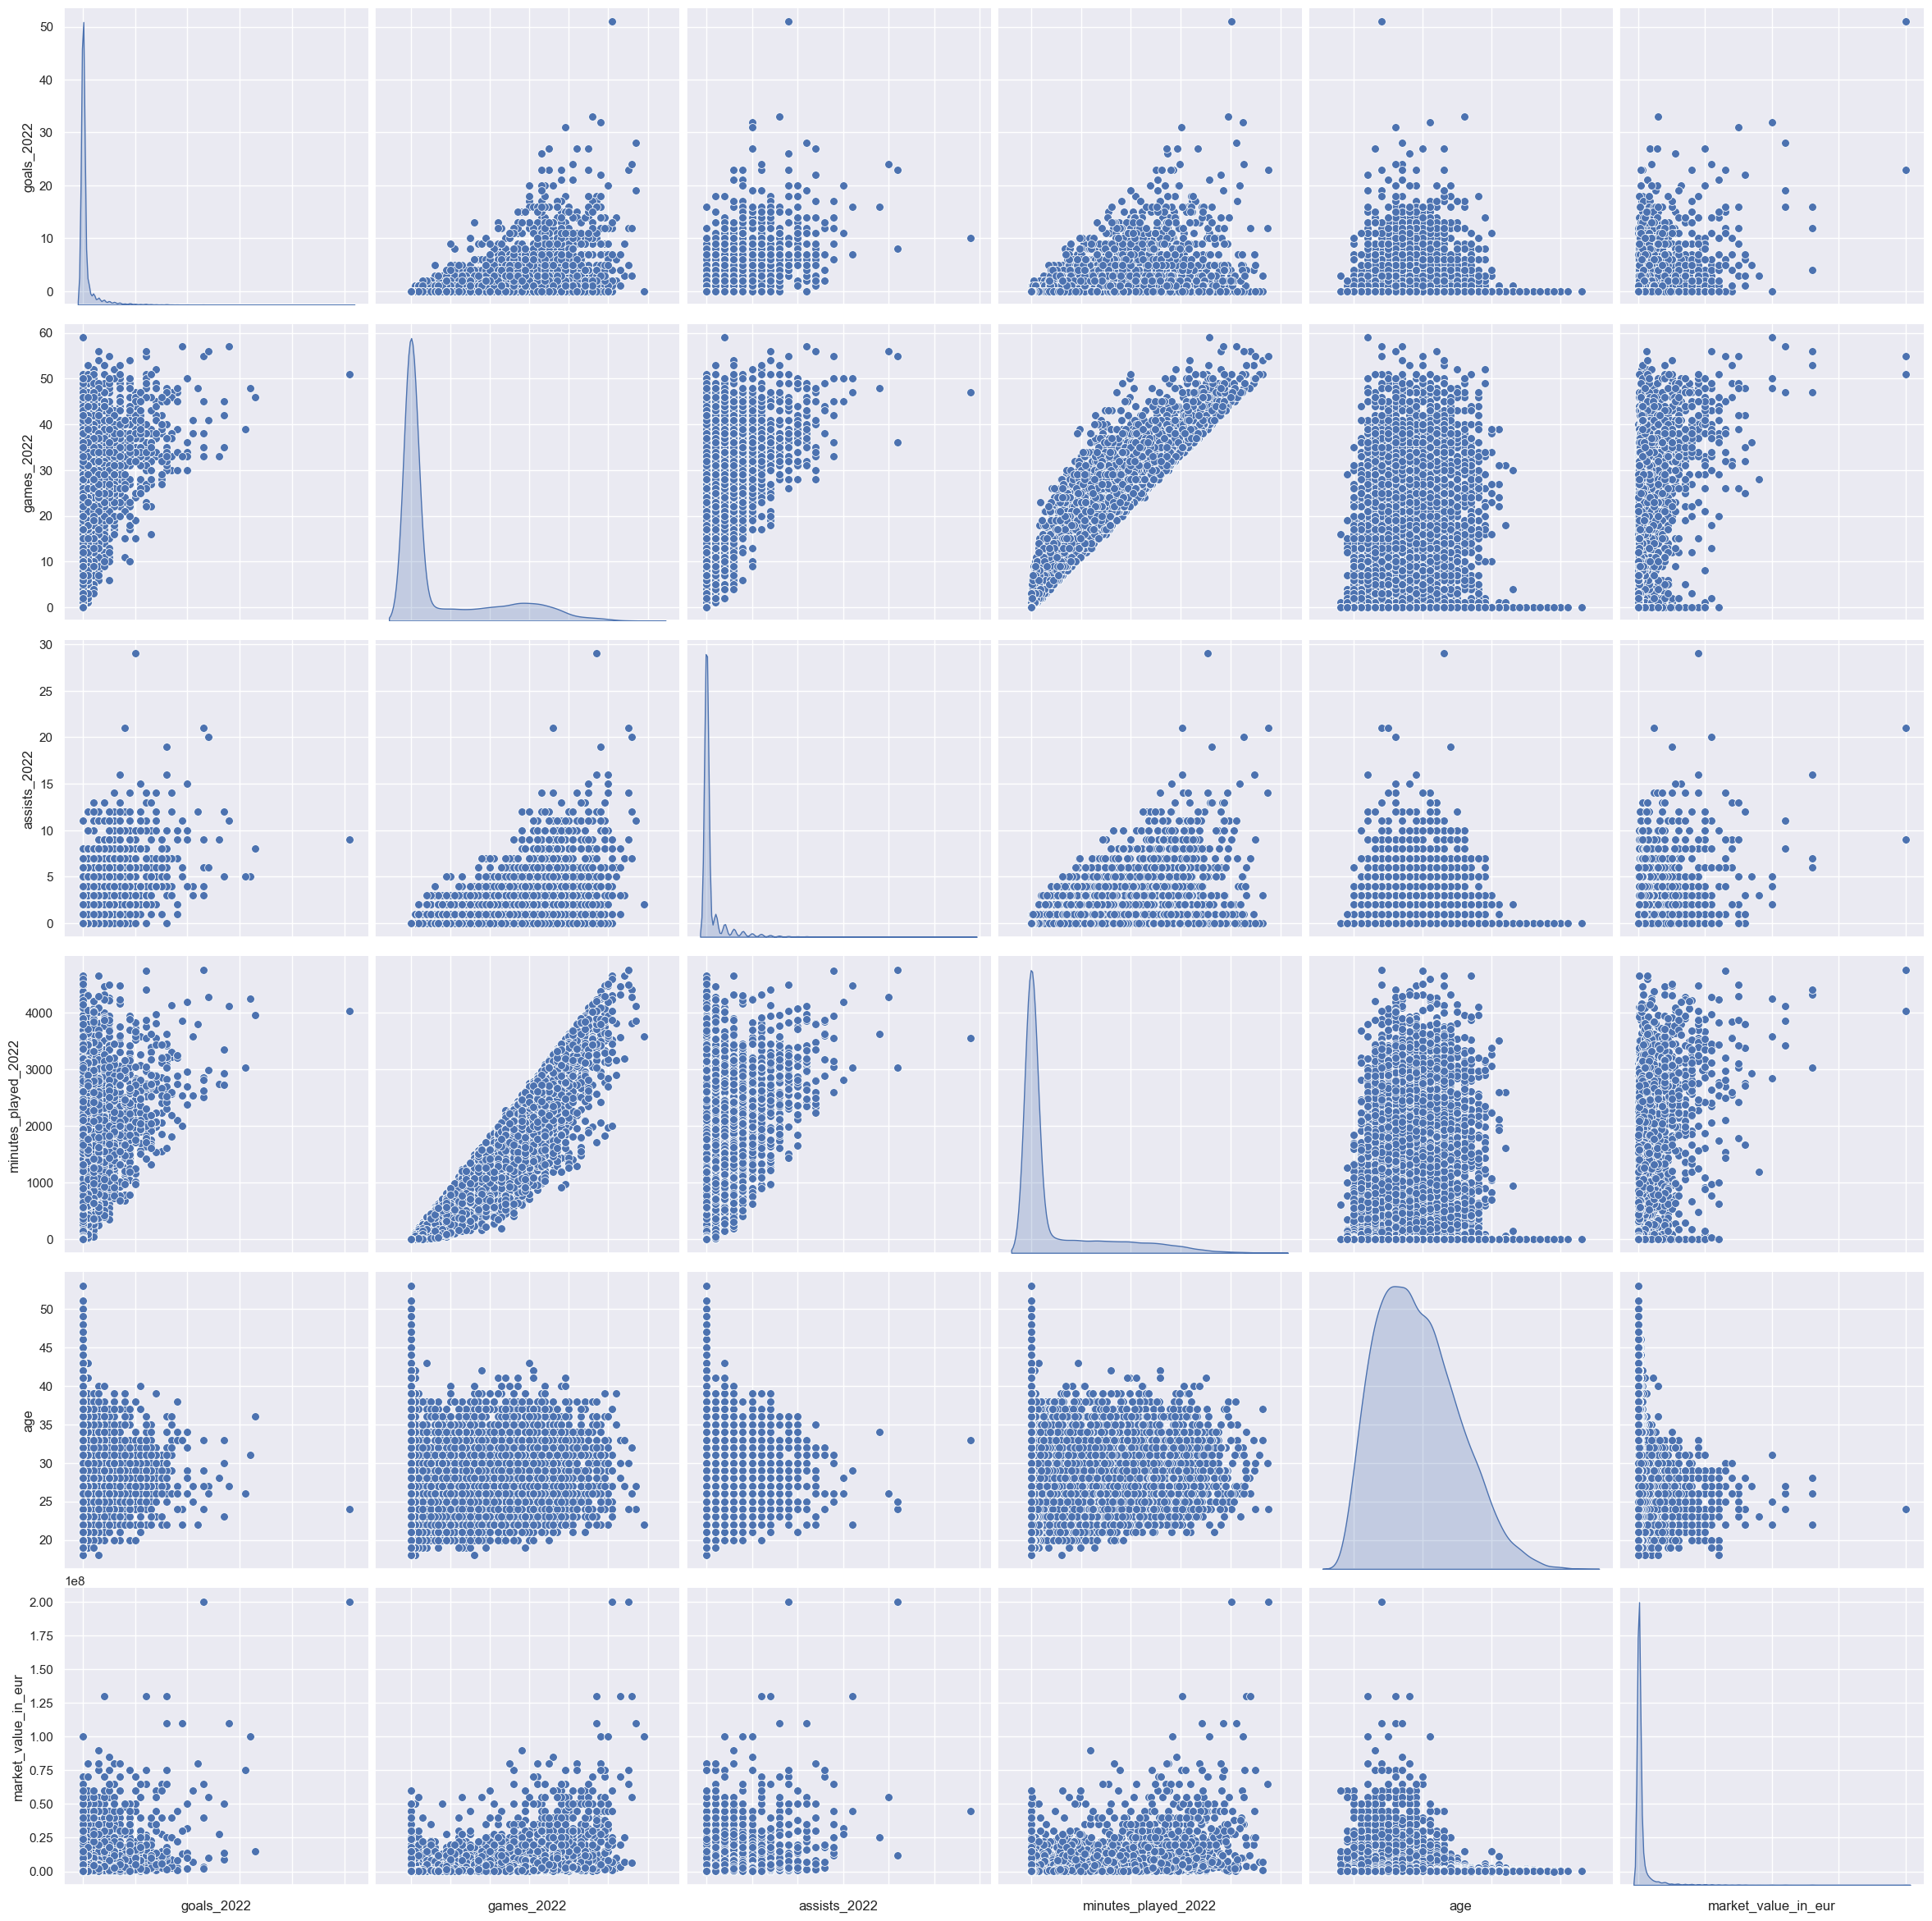

In [126]:
## Plot the pairplot
g = sns.pairplot(merged_df[[u'goals_2022', u'games_2022', u'assists_2022', u'minutes_played_2022',u'age',u'market_value_in_eur']], palette = 'seismic',size=4,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=50) )
g.set(xticklabels=[])

<Axes: title={'center': 'Pearson Correlation of Features'}>

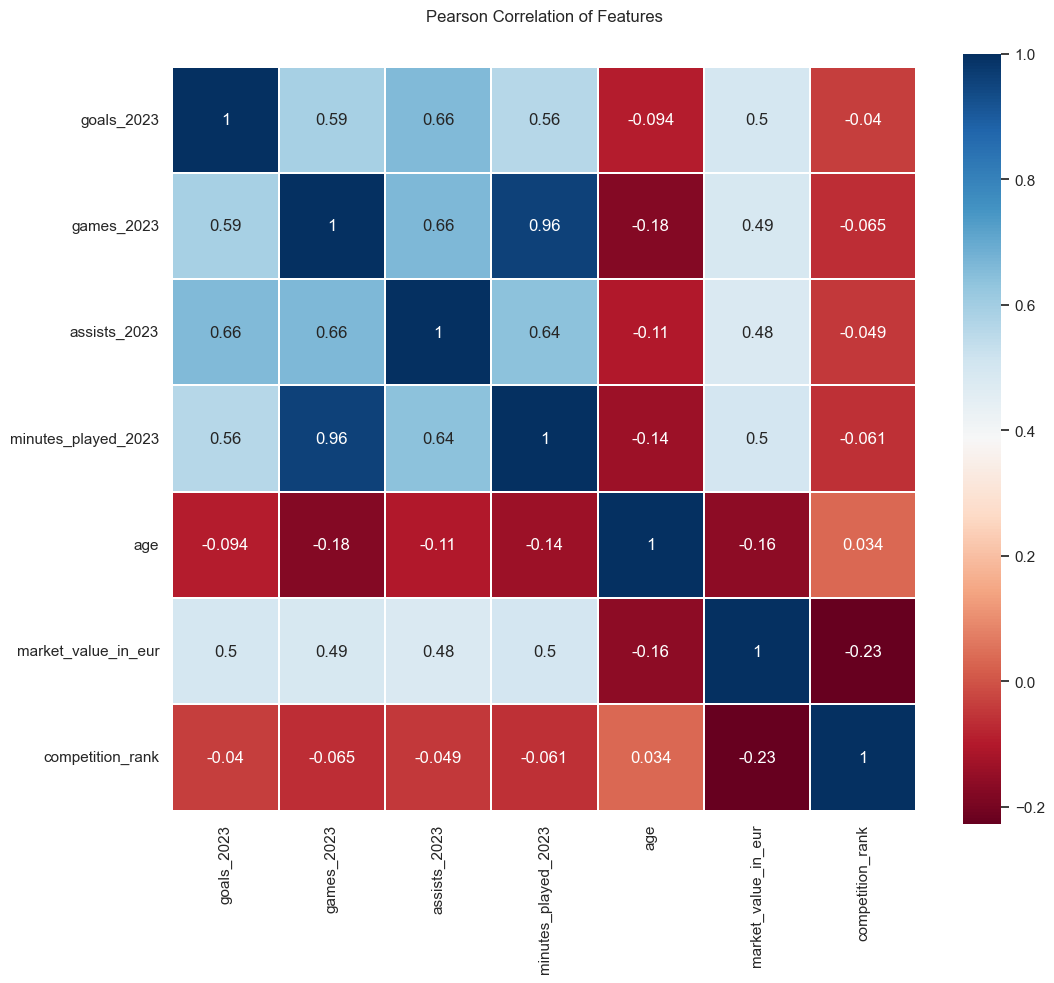

In [128]:
# Plot a Pearson Correlation Diagram
colormap = plt.cm.RdBu
plt.figure(figsize=(12,10))
plt.title('Pearson Correlation of Features', y=1.05)
#select columns height market_value age competition rank and all 2023 stats
features_df=merged_df[[u'goals_2023', u'games_2023', u'assists_2023', u'minutes_played_2023',u'age',u'market_value_in_eur',u'competition_rank']]
sns.heatmap(features_df.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True, cmap=colormap, linecolor='white', annot=True)

## Training Models

### Let's filter out the useful features to be used for training and testing

In [130]:
country_to_region = {
    # North America
    "United States": "North America",
    "Canada": "North America",
    "Mexico": "North America",
    
    # Central America
    "Guatemala": "Central America",
    "Honduras": "Central America",
    "El Salvador": "Central America",
    "Nicaragua": "Central America",
    "Costa Rica": "Central America",
    "Panama": "Central America",
    
    # South America
    "Brazil": "South America",
    "Argentina": "South America",
    "Colombia": "South America",
    "Chile": "South America",
    "Peru": "South America",
    "Venezuela": "South America",
    "Bolivia": "South America",
    "Ecuador": "South America",
    "Paraguay": "South America",
    "Uruguay": "South America",
    
    # Europe
    "United Kingdom": "Europe",
    "France": "Europe",
    "Germany": "Europe",
    "Italy": "Europe",
    "Spain": "Europe",
    "Portugal": "Europe",
    "Netherlands": "Europe",
    "Belgium": "Europe",
    "Sweden": "Europe",
    "Norway": "Europe",
    "Denmark": "Europe",
    "Finland": "Europe",
    "Poland": "Europe",
    "Russia": "Europe",
    "Ukraine": "Europe",
    "Greece": "Europe",
    "Hungary": "Europe",
    "Romania": "Europe",
    
    # Asia
    "China": "Asia",
    "India": "Asia",
    "Japan": "Asia",
    "South Korea": "Asia",
    "Philippines": "Asia",
    "Vietnam": "Asia",
    "Thailand": "Asia",
    "Malaysia": "Asia",
    "Indonesia": "Asia",
    "Pakistan": "Asia",
    "Bangladesh": "Asia",
    "Nepal": "Asia",
    "Sri Lanka": "Asia",
    "Myanmar": "Asia",
    "Kazakhstan": "Asia",
    "Afghanistan": "Asia",
    
    # Middle East
    "Turkey": "Middle East",
    "Iran": "Middle East",
    "Iraq": "Middle East",
    "Saudi Arabia": "Middle East",
    "Israel": "Middle East",
    "United Arab Emirates": "Middle East",
    "Jordan": "Middle East",
    "Lebanon": "Middle East",
    "Syria": "Middle East",
    "Yemen": "Middle East",
    "Oman": "Middle East",
    "Qatar": "Middle East",
    
    # Africa
    "Nigeria": "Africa",
    "South Africa": "Africa",
    "Egypt": "Africa",
    "Kenya": "Africa",
    "Ethiopia": "Africa",
    "Ghana": "Africa",
    "Uganda": "Africa",
    "Tanzania": "Africa",
    "Algeria": "Africa",
    "Morocco": "Africa",
    "Sudan": "Africa",
    "Angola": "Africa",
    "Ivory Coast": "Africa",
    "Cameroon": "Africa",
    "Mozambique": "Africa",
    "Zambia": "Africa",
    "Senegal": "Africa",
    "Zimbabwe": "Africa",
    
    # Oceania
    "Australia": "Oceania",
    "New Zealand": "Oceania",
    "Papua New Guinea": "Oceania",
    
    # Caribbean
    "Jamaica": "Caribbean",
    "Haiti": "Caribbean",
    "Dominican Republic": "Caribbean",
    "Cuba": "Caribbean",
    "Trinidad and Tobago": "Caribbean",
    "Barbados": "Caribbean",
    
    # Other
    "East Germany (GDR)": "Europe",
    "Austria": "Europe",
    "Switzerland": "Europe",
    "Jugoslawien (SFR)": "Europe",
    "England": "Europe",
    "Ireland": "Europe",
    "Iceland": "Europe",
    "Zaire": "Africa",
    "Northern Ireland": "Europe",
    "Guinea": "Africa",
    "UdSSR": "Europe",
    "Wales": "Europe",
    "Scotland": "Europe",
    "CSSR": "Europe",
    "Togo": "Africa",
    "Cote d'Ivoire": "Africa",
    "Türkiye": "Middle East",
    "Tunisia": "Africa",
    "Bulgaria": "Europe",
    "Gabon": "Africa",
    "Guadeloupe": "Caribbean",
    "Faroe Islands": "Europe",
    "Réunion": "Africa",
    "Azerbaijan": "Middle East",
    "Cape Verde": "Africa",
    "Luxembourg": "Europe",
    "Sierra Leone": "Africa",
    "Croatia": "Europe",
    "Mali": "Africa",
    "The Gambia": "Africa",
    "Burkina Faso": "Africa",
    "Malta": "Europe",
    "Burundi": "Africa",
    "Yugoslavia (Republic)": "Europe",
    "Albania": "Europe",
    "Congo": "Africa",
    "Guinea-Bissau": "Africa",
    "Andorra": "Europe",
    "Armenia": "Europe",
    "Bahrain": "Middle East",
    "Belarus": "Europe",
    "Benin": "Africa",
    "Bermuda": "Caribbean",
    "Bosnia-Herzegovina": "Europe",
    "Central African Republic": "Africa",
    "Chad": "Africa",
    "Comoros": "Africa",
    "Curacao": "Caribbean",
    "Cyprus": "Middle East",
    "Czech Republic": "Europe",
    "DR Congo": "Africa",
    "Djibouti": "Africa",
    "Dominica": "Caribbean",
    "Equatorial Guinea": "Africa",
    "Estonia": "Europe",
    "French Guiana": "South America",
    "Georgia": "Europe",
    "Hongkong": "Asia",
    "Isle of Man": "Europe",
    "Jersey": "Europe",
    "Korea, South": "Asia",
    "Kuwait": "Middle East",
    "Latvia": "Europe",
    "Liberia": "Africa",
    "Libya": "Africa",
    "Lithuania": "Europe",
    "Macedonia": "Europe",
    "Madagascar": "Africa",
    "Martinique": "Caribbean",
    "Mauritania": "Africa",
    "Mayotte": "Africa",
    "Moldova": "Europe",
    "Monaco": "Europe",
    "Netherlands Antilles": "Caribbean",
    "Palestine": "Middle East",
    "People's Republic of the Congo": "Africa",
    "Rwanda": "Africa",
    "Sao Tome and Principe": "Africa",
    "Serbia and Montenegro": "Europe",
    "Singapore": "Asia",
    "Slovakia": "Europe",
    "Slovenia": "Europe",
    "St. Lucia": "Caribbean",
    "Suriname": "South America",
    "Swaziland": "Africa",
    "Tajikistan": "Asia",
    "Turkmenistan": "Asia",
    "Uzbekistan": "Asia",
    "People's republic of the Congo": "Africa",
}


In [149]:
merged_df

,player_id,player_name,country_of_birth,country_of_citizenship,sub_position,position,foot,height_in_cm,agent_name,current_club_domestic_competition_id,...,yellow_cards_2020,yellow_cards_2021,yellow_cards_2022,yellow_cards_2023,red_cards_2020,red_cards_2021,red_cards_2022,red_cards_2023,competition_name,competition_rank
0,10,Miroslav Klose,Poland,Germany,Centre-Forward,Attack,right,184.0,ASBW Sport Marketing,IT1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,serie-a,7
1,26,Roman Weidenfeller,Germany,Germany,Goalkeeper,Goalkeeper,left,190.0,Neubauer 13 GmbH,L1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bundesliga,6
4,80,Tom Starke,East Germany (GDR),Germany,Goalkeeper,Goalkeeper,right,194.0,IFM,L1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bundesliga,6
18,447,Oka Nikolov,Germany,North Macedonia,Goalkeeper,Goalkeeper,right,188.0,PRO Profil GmbH,L1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bundesliga,6
32,823,Hanno Balitsch,Germany,Germany,Defensive Midfield,Midfield,right,182.0,Siebert & Backs,L1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bundesliga,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30829,1240467,Artem Prysyazhnyuk,Ukraine,Ukraine,Central Midfield,Midfield,left,180.0,Ivan Bobko,UKR1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,premier-liga,17
30831,1247360,Ivan M'Bahia,Cote d'Ivoire,Cote d'Ivoire,Centre-Back,Defender,right,174.0,BLACKSKILL,FR1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,ligue-1,8
30837,1294048,Alex Marques,Portugal,Portugal,Centre-Back,Defender,right,186.0,Livesoccer,PO1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,liga-portugal-bwin,10
30838,1294049,Tomás Silva,Portugal,Portugal,Left-Back,Defender,left,175.0,TGC,PO1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,liga-portugal-bwin,10


In [136]:
# train test split the dataset
test_df = merged_df.drop(['player_id', 'agent_name', 'player_name', 'competition_name', 'foot', 'country_of_citizenship', 'current_club_name', 'current_club_domestic_competition_id'],axis=1)

# add race column
def map_country_to_region(country):
    return country_to_region.get(country, 'Unknown')
test_df['region'] = test_df['country_of_birth'].apply(map_country_to_region)

# do onehotencoding on textual columns
X = test_df.drop(columns=["market_value_in_eur"])
encoder = OneHotEncoder(sparse_output=False) 
# encode sub_position
encoded_array = encoder.fit_transform(X[['sub_position']])
encoded_sub_position = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['sub_position']), index=X.index)
# encode region
encoded_array = encoder.fit_transform(X[['region']])
encoded_race = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['region']), index=X.index)
X.drop(['sub_position', 'country_of_birth', 'region', 'position'], axis=1, inplace=True)    

## USE X_NEW FOR TRAIN TEST SPLIT ##
X_new = pd.concat([X, encoded_sub_position], axis=1)
X_new = pd.concat([X_new, encoded_race], axis=1)
X_new = X_new.dropna()

y1 = np.log1p(test_df["market_value_in_eur"]) # log to make the market value smaller
X_train, X_test, y1_train, y1_test = train_test_split(X_new, y1, test_size=0.2, random_state=42)

In [137]:
## THE FINAL DATAFRAME TO USE FOR X
X_new.columns

Index(['height_in_cm', 'age', 'goals_2020', 'goals_2021', 'goals_2022',
       'goals_2023', 'games_2020', 'games_2021', 'games_2022', 'games_2023',
       'assists_2020', 'assists_2021', 'assists_2022', 'assists_2023',
       'minutes_played_2020', 'minutes_played_2021', 'minutes_played_2022',
       'minutes_played_2023', 'goals_for_2020', 'goals_for_2021',
       'goals_for_2022', 'goals_for_2023', 'goals_against_2020',
       'goals_against_2021', 'goals_against_2022', 'goals_against_2023',
       'clean_sheet_2020', 'clean_sheet_2021', 'clean_sheet_2022',
       'clean_sheet_2023', 'yellow_cards_2020', 'yellow_cards_2021',
       'yellow_cards_2022', 'yellow_cards_2023', 'red_cards_2020',
       'red_cards_2021', 'red_cards_2022', 'red_cards_2023',
       'competition_rank', 'sub_position_Attacking Midfield',
       'sub_position_Central Midfield', 'sub_position_Centre-Back',
       'sub_position_Centre-Forward', 'sub_position_Defensive Midfield',
       'sub_position_Goalkeeper',

### Linear Regression

In [138]:
# try a Linear Regression model
LnrReg1 = LinearRegression().fit(X_train, y1_train)
y1_pred_lnr = LnrReg1.predict(X_test)

mae_lnr = mean_absolute_error(y1_test, y1_pred_lnr)
mse_lnr = mean_squared_error(y1_test, y1_pred_lnr)
rmse_lnr = np.sqrt(mse_lnr)
r2_lnr = r2_score(y1_test, y1_pred_lnr)

print(f"Linear Regression Results:")
print(f"Mean Absolute Error (MAE): {mae_lnr}")
print(f"Mean Squared Error (MSE): {mse_lnr}")
print(f"Root Mean Squared Error (RMSE): {rmse_lnr}")
print(f"R-squared (R²): {r2_lnr}")

Linear Regression Results:
Mean Absolute Error (MAE): 0.7873446988423268
Mean Squared Error (MSE): 1.0352766844822234
Root Mean Squared Error (RMSE): 1.017485471386311
R-squared (R²): 0.5948010675952556


### ElasticNet

In [139]:
# try a ElasticNet model
ElasticNet1 = ElasticNet().fit(X_train, y1_train)
y1_pred_en = ElasticNet1.predict(X_test)

mae_en = mean_absolute_error(y1_test, y1_pred_en)
mse_en = mean_squared_error(y1_test, y1_pred_en)
rmse_en = np.sqrt(mse_en)
r2_en = r2_score(y1_test, y1_pred_en)

print(f"ElasticNet Results:")
print(f"Mean Absolute Error (MAE): {mae_en}")
print(f"Mean Squared Error (MSE): {mse_en}")
print(f"Root Mean Squared Error (RMSE): {rmse_en}")
print(f"R-squared (R²): {r2_en}")

ElasticNet Results:
Mean Absolute Error (MAE): 0.8271511814462396
Mean Squared Error (MSE): 1.1456656875622735
Root Mean Squared Error (RMSE): 1.0703577381241627
R-squared (R²): 0.5515957033986969


### Random Forest Regressor

In [140]:
# try a Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y1_train)
y1_pred_rf = rf_regressor.predict(X_test)

mae_rf = mean_absolute_error(y1_test, y1_pred_rf)
mse_rf = mean_squared_error(y1_test, y1_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y1_test, y1_pred_rf)

print(f"Random Forest Regressor Results:")
print(f"Mean Absolute Error (MAE): {mae_rf}")
print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf}")
print(f"R-squared (R²): {r2_rf}")

Random Forest Regressor Results:
Mean Absolute Error (MAE): 0.6979354634347908
Mean Squared Error (MSE): 0.8510973343744437
Root Mean Squared Error (RMSE): 0.9225493669037141
R-squared (R²): 0.6668873776158436


### XGBoost Regressor

In [154]:
# try a XGBoost Regressor model (THIS HAS THE GRIDSEARCHCV RECOMMENDED VALUES FROM BELOW IMPLEMENTED)
xgb_regressor = XGBRegressor(n_estimators=500, learning_rate=0.03, max_depth=6, subsample=0.9, colsample_bytree=0.6, random_state=42)
xgb_regressor.fit(X_train, y1_train)
y1_pred_xgb = xgb_regressor.predict(X_test)

mae_xgb = mean_absolute_error(y1_test, y1_pred_xgb)
mse_xgb = mean_squared_error(y1_test, y1_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y1_test, y1_pred_xgb)

print(f"XGBoost Regressor Results:")
print(f"Mean Absolute Error (MAE): {mae_xgb}")
print(f"Mean Squared Error (MSE): {mse_xgb}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb}")
print(f"R-squared (R²): {r2_xgb}")

XGBoost Regressor Results:
Mean Absolute Error (MAE): 0.6431820639267242
Mean Squared Error (MSE): 0.732756024337344
Root Mean Squared Error (RMSE): 0.8560116963788194
R-squared (R²): 0.7132052105248248


## Hyper-Parameter Tuning

### We will use our best model, XGBoost Regressor, for tuning

In [153]:
xgb_regressor = XGBRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300, 350, 400, 450, 500],
    'learning_rate': [0.01, 0.03, 0.04, 0.05, 0.06, 0.07, 0.1],
    'max_depth': [4, 5, 6],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(
    estimator=xgb_regressor,
    param_grid=param_grid,
    scoring='neg_mean_squared_error', 
    cv=5,                             
    verbose=1,
    n_jobs=-1                         
)

grid_search.fit(X_train, y1_train)
best_xgb_regressor = grid_search.best_estimator_
y1_pred_best_xgb = best_xgb_regressor.predict(X_test)

mae_best_xgb = mean_absolute_error(y1_test, y1_pred_best_xgb)
mse_best_xgb = mean_squared_error(y1_test, y1_pred_best_xgb)
rmse_best_xgb = np.sqrt(mse_best_xgb)
r2_best_xgb = r2_score(y1_test, y1_pred_best_xgb)

print("Best Parameters:", grid_search.best_params_)
print("\nTuned XGBoost Regressor Results:")
print(f"Mean Absolute Error (MAE): {mae_best_xgb}")
print(f"Mean Squared Error (MSE): {mse_best_xgb}")
print(f"Root Mean Squared Error (RMSE): {rmse_best_xgb}")
print(f"R-squared (R²): {r2_best_xgb}")

Fitting 5 folds for each of 2352 candidates, totalling 11760 fits
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 500, 'subsample': 0.9}

Tuned XGBoost Regressor Results:
Mean Absolute Error (MAE): 0.6431820639267242
Mean Squared Error (MSE): 0.732756024337344
Root Mean Squared Error (RMSE): 0.8560116963788194
R-squared (R²): 0.7132052105248248


Fitting 5 folds for each of 2352 candidates, totalling 11760 fits
### Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 500, 'subsample': 0.9}

Tuned XGBoost Regressor Results:
- Mean Absolute Error (MAE): 0.6431820639267242
- Mean Squared Error (MSE): 0.732756024337344
- Root Mean Squared Error (RMSE): 0.8560116963788194
- R-squared (R²): 0.7132052105248248

## Training Analysis

### Feature Importance for XGBoost Model

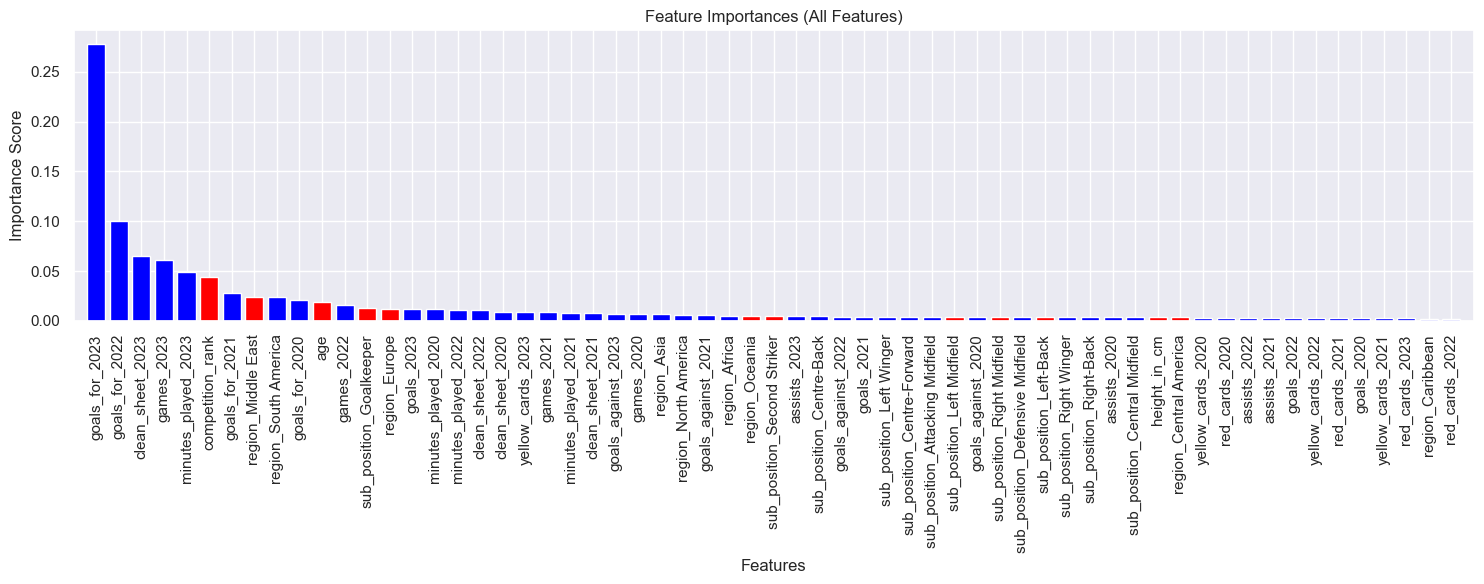

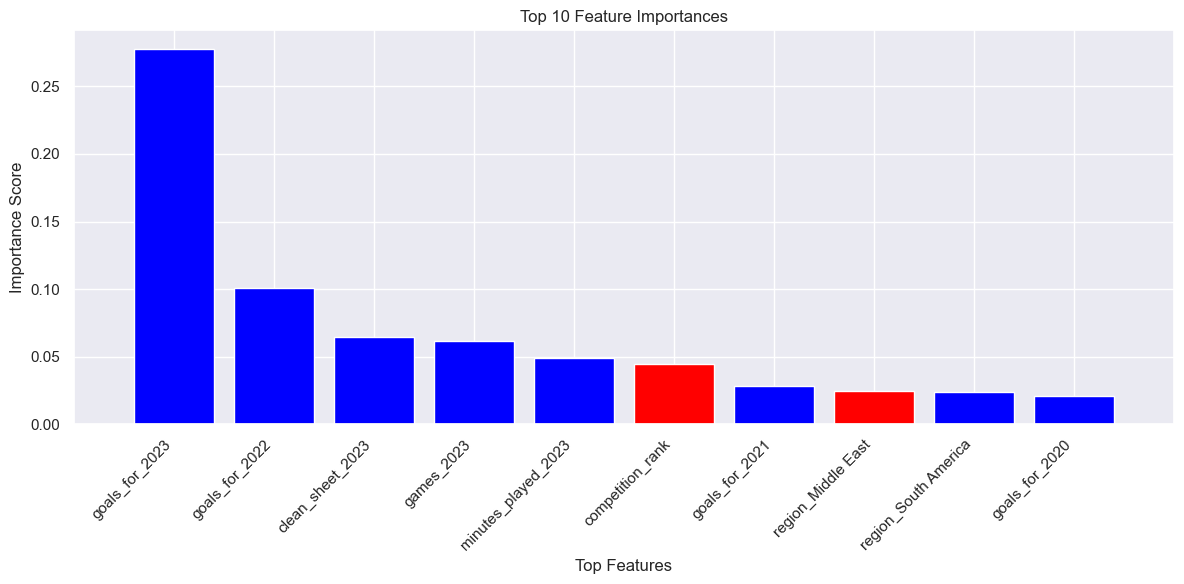

In [155]:
#show feature importance
correlations = np.array([np.corrcoef(X_train.iloc[:, i], y1_train)[0, 1] 
                         for i in range(X_train.shape[1])])

# Get feature importances from the XGBoost model
importances = xgb_regressor.feature_importances_

# Sort feature indices by importance in descending order
indices = np.argsort(importances)[::-1]

# -------------------- Plot All Feature Importances --------------------
plt.figure(figsize=(15, 6))
plt.title("Feature Importances (All Features)")

# Set colors: blue for positive correlations, red for negative
colors_all = ['blue' if correlations[i] >= 0 else 'red' for i in indices]

plt.bar(range(X_train.shape[1]), importances[indices], color=colors_all, align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.tight_layout()
plt.show()

# -------------------- Plot Top 10 Feature Importances --------------------
# Define the number of top features to display
top_n = 10

# Select the top_n indices
top_indices = indices[:top_n]

plt.figure(figsize=(12, 6))
plt.title(f"Top {top_n} Feature Importances")

# Set colors for top features
colors_top = ['blue' if correlations[i] >= 0 else 'red' for i in top_indices]

plt.bar(range(top_n), importances[top_indices], color=colors_top, align="center")
plt.xticks(range(top_n), X_train.columns[top_indices], rotation=45, ha='right')
plt.xlim([-1, top_n])
plt.ylabel("Importance Score")
plt.xlabel("Top Features")
plt.tight_layout()
plt.show()

### Error Analysis

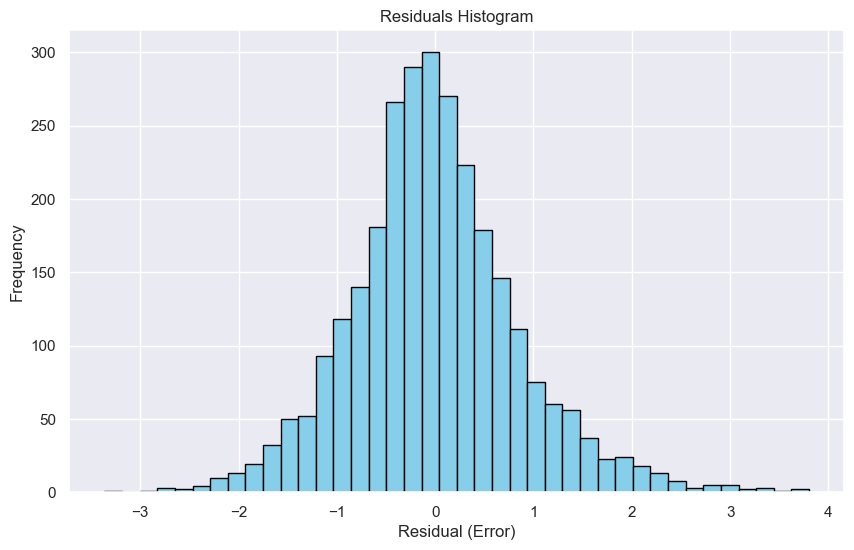

In [157]:
residuals = y1_test - y1_pred_xgb  # Calculate residuals

# Plot histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=40, color='skyblue', edgecolor='black')
plt.title('Residuals Histogram')
plt.xlabel('Residual (Error)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()